In [9]:
''' mainly used to make sure that C nmr works better than HSQC'''

import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            


In [10]:
import numpy as np 
import random
seed=2
# pl.seed_everything(seed,  workers=True)
# torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


In [11]:
# load model 

# Choice 1: flexible model
model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/flexible_models_best_FP/r0_r2_FP_trial_2/")
checkpoint_path = model_path / "checkpoints/epoch=42-all_inputs.ckpt"

# Choice  2: all-three nmr model
# model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/entropy_radius_exps_all_info/R0_to_R4_all_info_trial_1")
# checkpoint_path = model_path / "checkpoints/epoch=22-step=11408.ckpt"



hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
print(FP_building_type)
max_radius = int(hparams['FP_choice'].split("_")[-1][1:])
print("max_radius: ", max_radius)
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




Normal
max_radius:  2


In [12]:

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [13]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

In [14]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")



all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/smart4.5/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))



In [15]:
# len(all_FP_indices_in_folder), len(all_added_smiles), len(all_FP_indices_to_be_added)

In [16]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

all_file_indices = [int(i.split(".")[0]) for i in loader_only_hsqc.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [17]:
which_compound = 5
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
print(filename)

Chemspider_Pyristriatin A
COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C
10022.pt


In [18]:
(index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

('COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C',
 'Chemspider_Pyristriatin A')

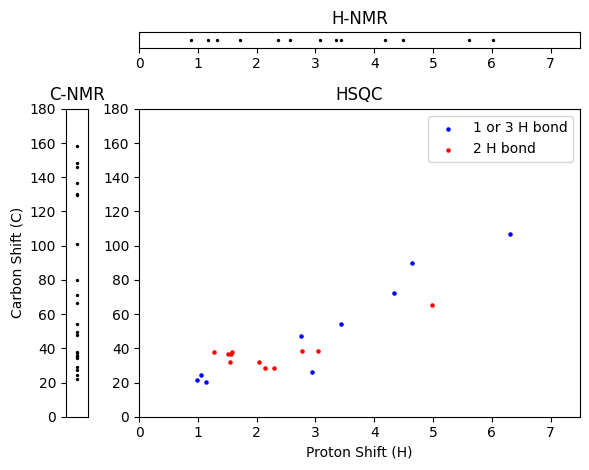

In [19]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_NMR(hsqc, c_tensor, h_tensor):
    # print(hsqc, c_tensor, h_tensor)
    # Create a 2x2 grid for subplots
    fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

    # Create subplots in different locations and sizes
    ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
    if hsqc is not None:
        pos = hsqc[hsqc[:,2]>0]
        neg = hsqc[hsqc[:,2]<0]
        ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
        ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
        # print("scatter!!")
        # print(pos, neg)
    ax1.set_title("HSQC")
    ax1.set_xlabel('Proton Shift (H)')  # X-axis label
    ax1.set_xlim([0, 7.5])
    ax1.set_ylim([0, 180])
    ax1.legend()


    ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
    if c_tensor is not None:
        ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
    ax2.set_ylim([0, 180])
    ax2.set_title("C-NMR")
    ax2.set_ylabel('Carbon Shift (C)')
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
    if h_tensor is not None:
        ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
    ax3.set_xlim([0, 7.5])
    ax3.set_title("H-NMR")
    ax3.set_yticks([])

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_NMR(hsqc, c_tensor, h_tensor)

In [20]:
import torch.nn.functional as F
import heapq

def retrieve_top_k_by_dir(dir, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()
    results = []
    for  ranker_f in sorted(os.listdir(dir), key=lambda x:int(x.split("_")[1].split(".")[0])):
    # for num_ranker_data, ranker_f in [(54,"FP_54.pt")]:
        # print(ranker_f)
        num_ranker_data = int(ranker_f.split("_")[1].split(".")[0])
        data = torch.load(os.path.join(dir, ranker_f)).to("cuda")
        query_products = (data @ query)
        values, indices = torch.topk(query_products,k=k)
        if len(results) == 0:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappush(results, (value, real_idx, data[idx].nonzero()))
        else:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappushpop(results, (value, real_idx, data[idx].nonzero()))    
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret

def retrieve_top_k_by_rankingset(data, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()

    results = []
    query_products = (data @ query)
    values, indices = torch.topk(query_products,k=k)
    
    for value, idx in zip(values, indices):
        results.append((value, idx, data[idx].nonzero()))
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret
        

In [21]:
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names.pkl', 'rb'))
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_only_2d_dataset.pkl', 'rb'))
smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_remove_stereoChemistry.pkl', 'rb'))

# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/test_smiles_and_names.pkl', 'rb'))

In [22]:
# rankingset_path = '/root/MorganFP_prediction/inference_data/max_radius_2_only_2d_False_together_only_2d_dataset/FP.pt'
rankingset_path = f'/root/MorganFP_prediction/inference_data/max_radius_{max_radius}_only_2d_False_together_no_stereoChemistry_dataset/FP.pt'

rankingset_data = torch.load(rankingset_path).to("cuda")

smiles_to_NMR_path = pickle.load(open('/root/MorganFP_prediction/inference_data/SMILES_chemical_to_NMR_paths.pkl','rb'))

In [23]:
smiles_to_NMR_path['COC1OC(CO)C(O)C(O)C1O']

('/workspace/SMILES_dataset/test/HSQC/10002.pt',
 '/workspace/SMILES_dataset/test/oneD_NMR/10002.pt')

In [24]:
def unpack_inputs(inputs):
    for i, vals in enumerate(inputs[0]):
        # if vals is [-1, -1, -1]
        if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
            hsqc_start=i+1
        elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
            hsqc_end=i
        elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
            c_nmr_start=i+1
        elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
            c_nmr_end=i
        elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
            h_nmr_start=i+1
        elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
            h_nmr_end=i
            
    hsqc = inputs[0,hsqc_start:hsqc_end]
    c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
    h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
    return hsqc, c_tensor, h_tensor

# unpack_inputs(inputs)

# !!!
def compute_cos_sim(fp1, fp2):
    return (fp1 @ fp2) / (torch.norm(fp1) * torch.norm(fp2)).item()

############################################### compound number: 3478##############################################################


Ground Truth NMR


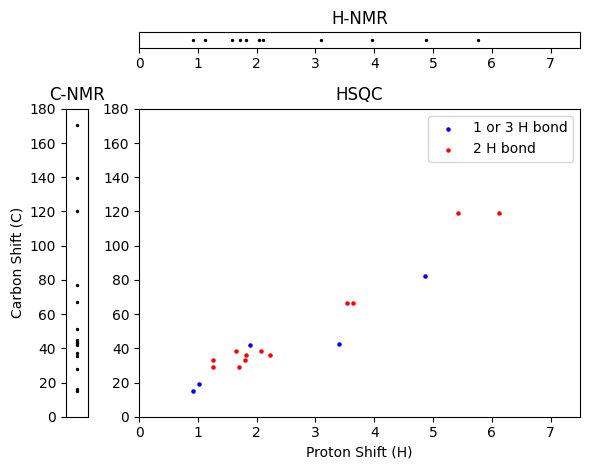

Chemical name 90039-69-3
Ground truth smiles C=C1C(=O)OC2CC3(CC12)C(C)CCC3(C)CO


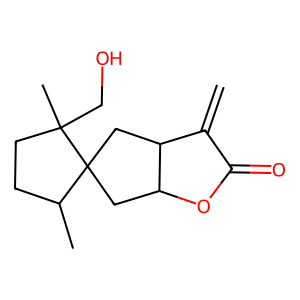

Prediction's cosine similarity to ground truth:  0.9040535092353821
SMILES: C=C1C(=O)OC2CC3(CC12)C(C)CCC3(C)CO
Name 90039-69-3


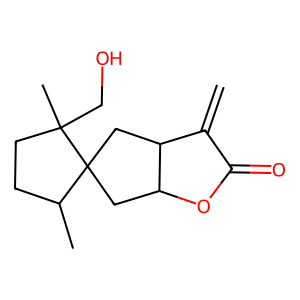

In [26]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# model.to("cuda")
for  which_compound in  random.sample(range(len(loader_all_inputs.dataset)), k=1):# range(0, 1):  
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(loader_all_inputs):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
        inputs = inputs.to("cuda")
        pred = model(inputs)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    plot_NMR(hsqc, c_tensor, h_tensor)
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    # ground truth
    smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
    
    i=0
    for value, (smile, name, _, _), retrieved_FP in topk:
        # print(f"________retival #{i+1}, cosine similarity: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())
        hsqc_path, oned_path = smiles_to_NMR_path[smile]
        #check is path file exists
        hsqc, c_tensor, h_tensor = None, None, None
        # print("retrieved path: ",oned_path)
        if os.path.exists(hsqc_path):
            hsqc = torch.load(hsqc_path)
        if os.path.exists(oned_path):
            c_tensor, h_tensor = torch.load(oned_path)
        # plot_NMR(hsqc, c_tensor, h_tensor)
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



____________________incorrect retival #2________________________
Ground Truth NMR


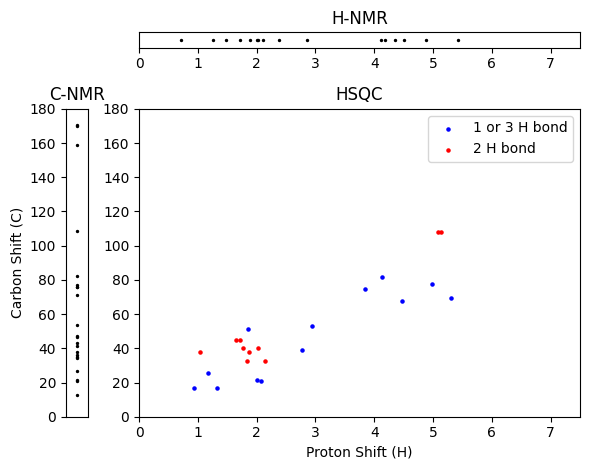

Prediction's cosine similarity to ground truth:  0.8786954283714294
Chemical name Inflexarabdonin A
Ground truth smiles C=C1C2CC(OC(C)=O)C3C(C2)(CC(O)C2C(C)(C)C(OC(C)=O)CC(O)C23C)C1O


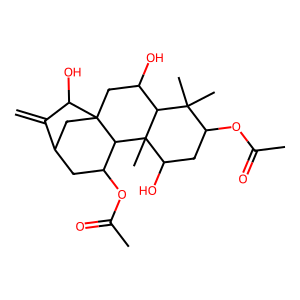

SMILES: C=C1C2CC(O)C3C(C2)(CC(OC(C)=O)C2C(C)(C)C(OC(C)=O)CC(O)C23C)C1O
Name 6-(acetyloxy)-8,11,15-trihydroxy-5,5,9-trimethyl-14-methylidenetetracyclo[11.2.1.0¹,¹⁰.0⁴,⁹]hexadecan-3-yl acetate


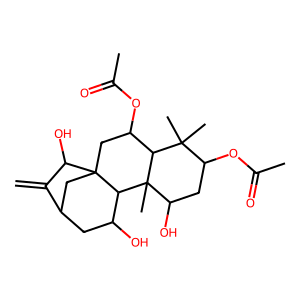

____________________incorrect retival #3________________________
Ground Truth NMR


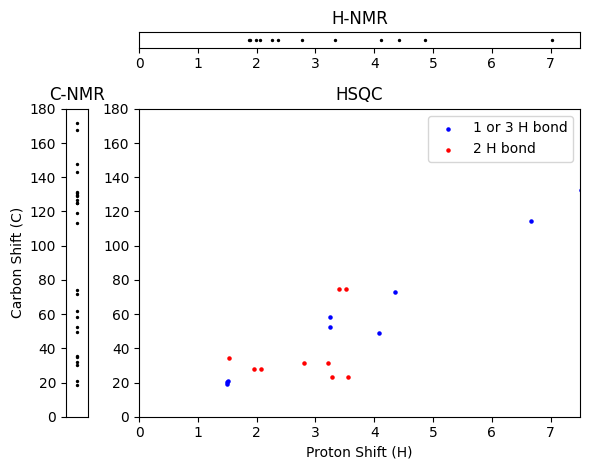

Prediction's cosine similarity to ground truth:  0.6168551445007324
Chemical name JBIR-73
Ground truth smiles COCC1(CCC(C)=C(C)C)Nc2ccc(C(=O)O)cc2CC1Sc1ncc(CC(C(=O)O)[N+](C)(C)C)[nH]1


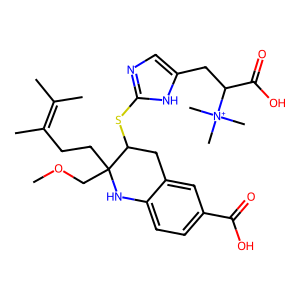

SMILES: COCC1(CCC(C)=C(C)C)Nc2ccc(C(=O)O)cc2CC1O
Name A-503451 D


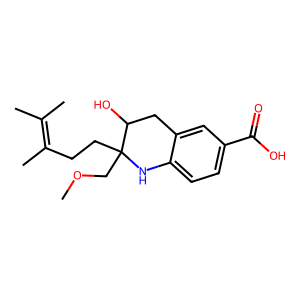

____________________incorrect retival #4________________________
Ground Truth NMR


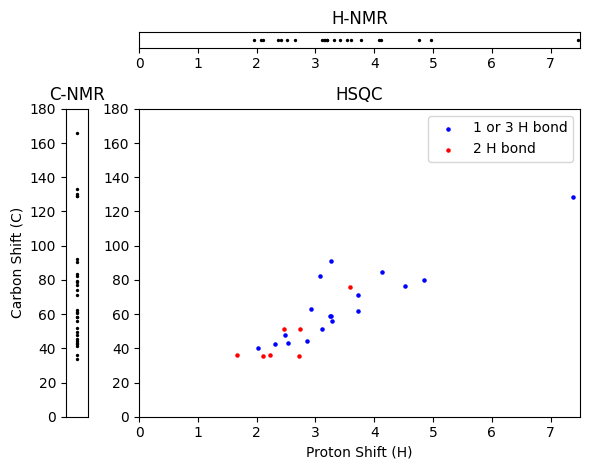

Prediction's cosine similarity to ground truth:  0.8360556364059448
Chemical name Hokbusine A
Ground truth smiles COCC12CN(C)C3C4C(OC)C1C3(C(OC)CC2O)C1CC2(O)C(OC)C(O)C4(OC)C1C2OC(=O)c1ccccc1


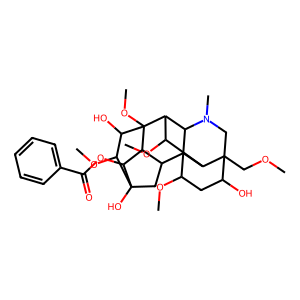

SMILES: COCC12CN(C)C3C4C(OC)C1C3(C(OC)CC2O)C1CC2(O)C(OC)C(O)C4(O)C1C2OC(=O)c1ccccc1
Name Benzoylmesaconine


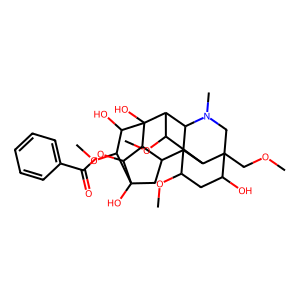

____________________incorrect retival #5________________________
Ground Truth NMR


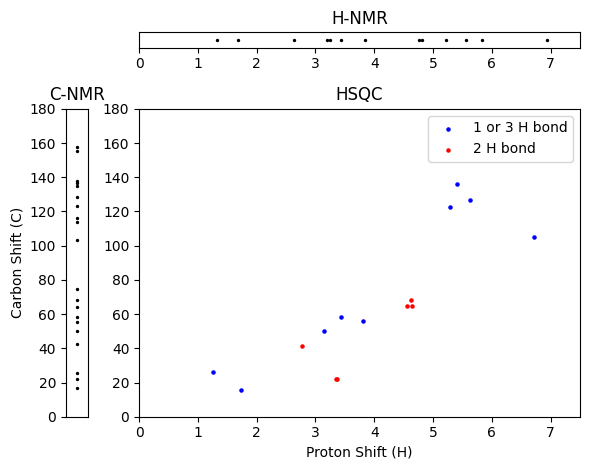

Prediction's cosine similarity to ground truth:  0.8289099335670471
Chemical name Hericenol D
Ground truth smiles COCc1c(CO)cc(OC)c(CC=C(C)CC=CC(C)(C)OC)c1O


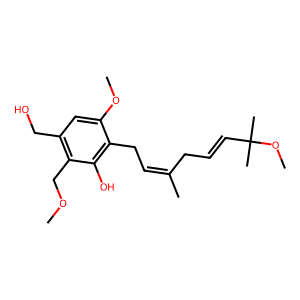

SMILES: COCc1c(CO)cc(OC)c(CC=C(C)CC=CC(C)(C)O)c1O
Name hericenol C


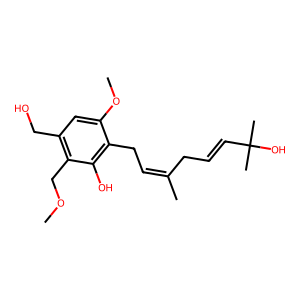

____________________incorrect retival #6________________________
Ground Truth NMR


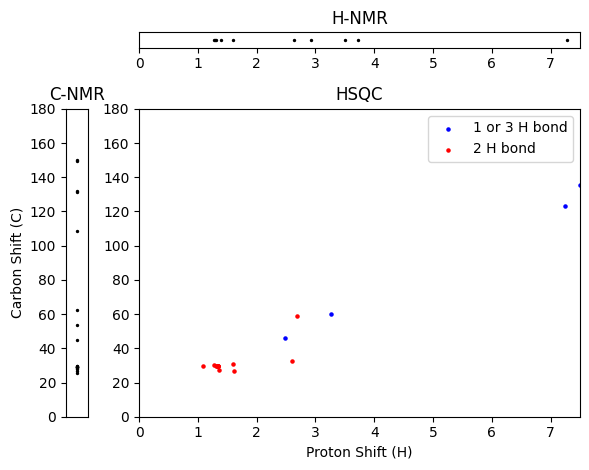

Prediction's cosine similarity to ground truth:  0.8143279552459717
Chemical name xestamine E
Ground truth smiles CON(C)CCCCCCCCCCCCCCCc1cccnc1


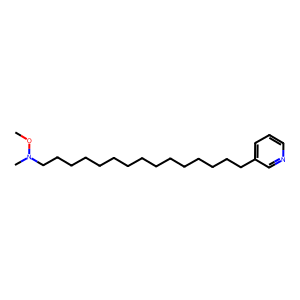

SMILES: CON(C)CCCCCCCCCCCCCCc1cccnc1
Name xestamine D


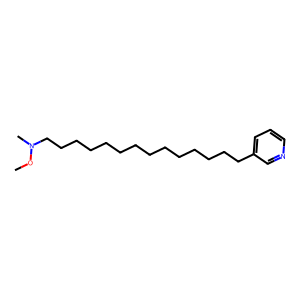

____________________incorrect retival #7________________________
Ground Truth NMR


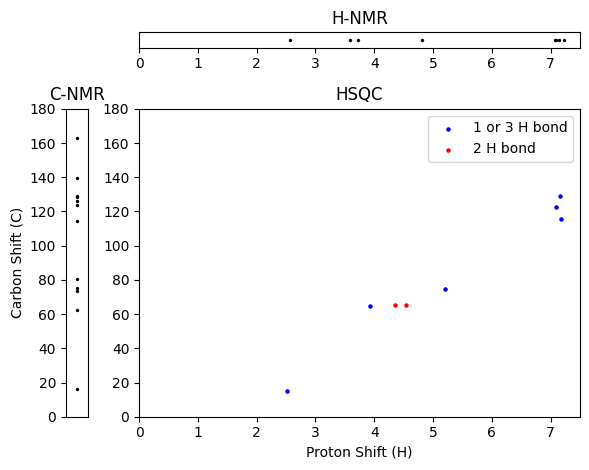

Prediction's cosine similarity to ground truth:  0.5364950299263
Chemical name Dihydroerucalexin
Ground truth smiles CON1c2ccccc2C(O)C12CN=C(SC)S2


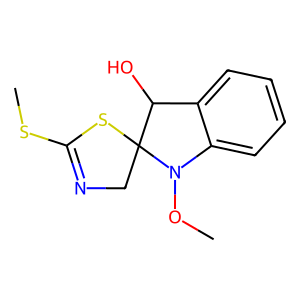

SMILES: CCC1NC2CC3(C(=O)N(OC)c4ccccc43)C3OCC2C1C3O
Name Hydroxygelsemicine


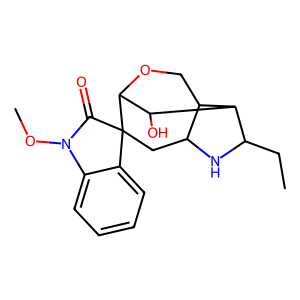

____________________incorrect retival #8________________________
Ground Truth NMR


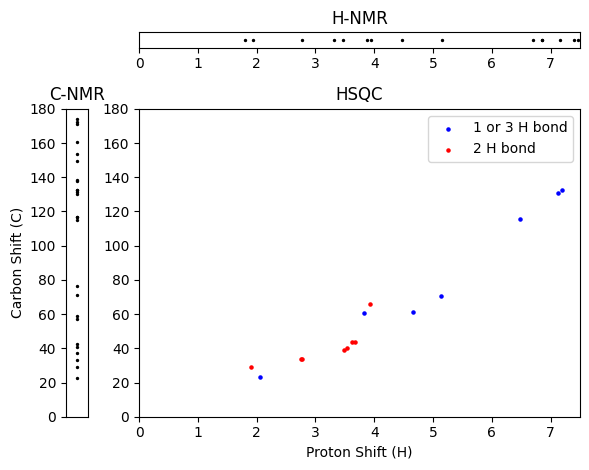

Prediction's cosine similarity to ground truth:  0.7253046035766602
Chemical name itampolin B
Ground truth smiles COc1c(Br)cc(C(O)C(NC(=O)Cc2ccc(OCCCNC(C)=O)cc2)C(=O)NCCc2cc(Br)c(O)c(Br)c2)cc1Br


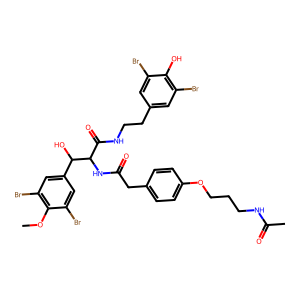

SMILES: COc1c(Br)cc(CC(NC(=O)Cc2ccc(OCCCNC(C)=O)cc2)C(=O)NCCc2cc(Br)c(O)c(Br)c2)cc1Br
Name itampolin A


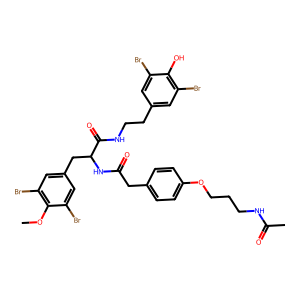

____________________incorrect retival #9________________________
Ground Truth NMR


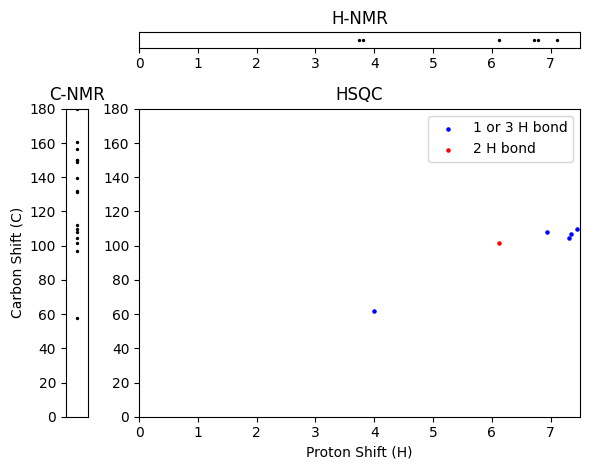

Prediction's cosine similarity to ground truth:  0.7799203395843506
Chemical name 42607787
Ground truth smiles COc1c(C(=O)c2ccc3c(c2)OCO3)oc2c1ccc1occc12


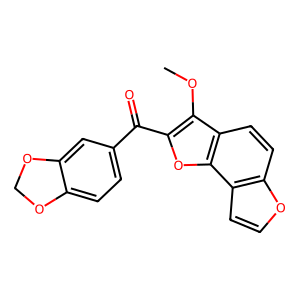

SMILES: COc1c(-c2ccc3c(c2)OCO3)oc2c(ccc3occc32)c1=O
Name Pongapin


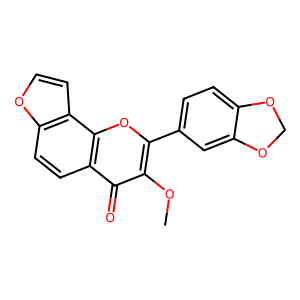

____________________incorrect retival #10________________________
Ground Truth NMR


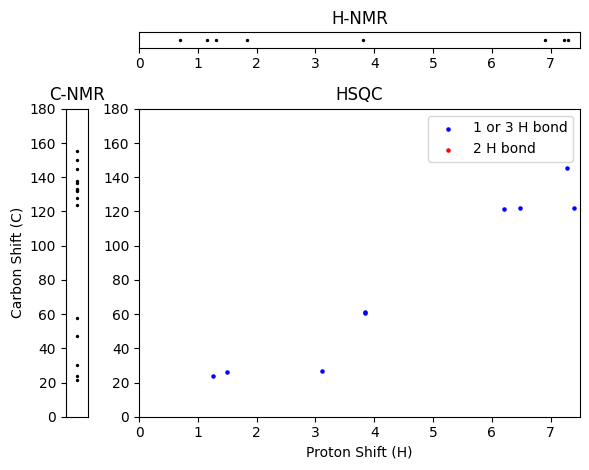

Prediction's cosine similarity to ground truth:  0.7203697562217712
Chemical name 110300-77-1
Ground truth smiles COc1c(C(C)C)cc2c(=O)cc3c(cc2c1OC)C=CC(=O)C3(C)C


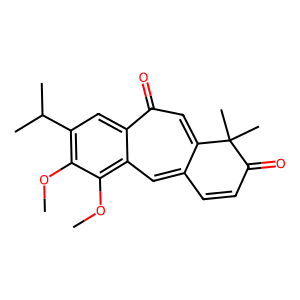

SMILES: COc1c(C(C)C)cc2ccc3c(c(=O)c2c1O)C=CC(=O)C3(C)C
Name 100952784


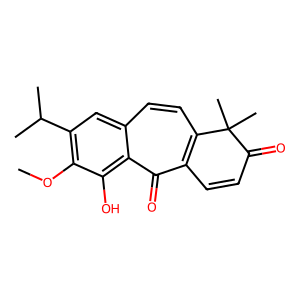

____________________incorrect retival #11________________________
Ground Truth NMR


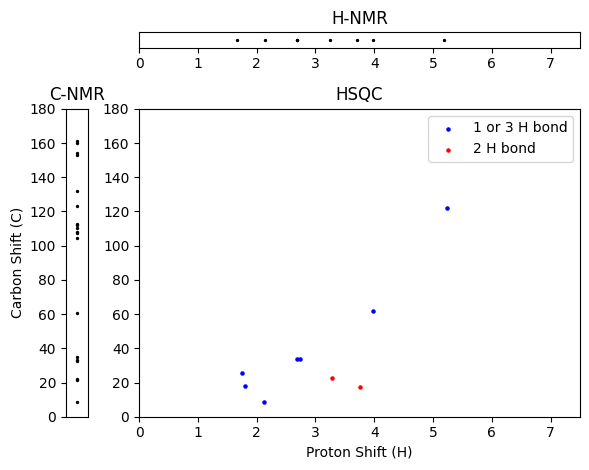

Prediction's cosine similarity to ground truth:  0.8797735571861267
Chemical name Mallotojaponin
Ground truth smiles COc1c(C)c(O)c(C(C)=O)c(O)c1Cc1c(O)c(CC=C(C)C)c(O)c(C(C)=O)c1O


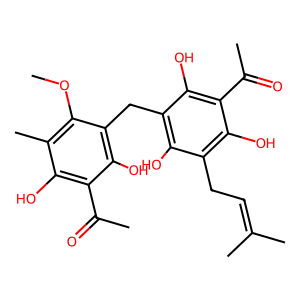

SMILES: COc1c(C)c(O)c(C(C)=O)c(O)c1Cc1c(O)c(C(C)=O)c(O)c(CC=C(C)C)c1OC
Name mallotojaponin B


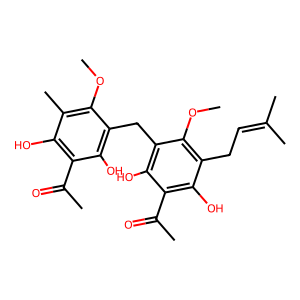

____________________incorrect retival #12________________________
Ground Truth NMR


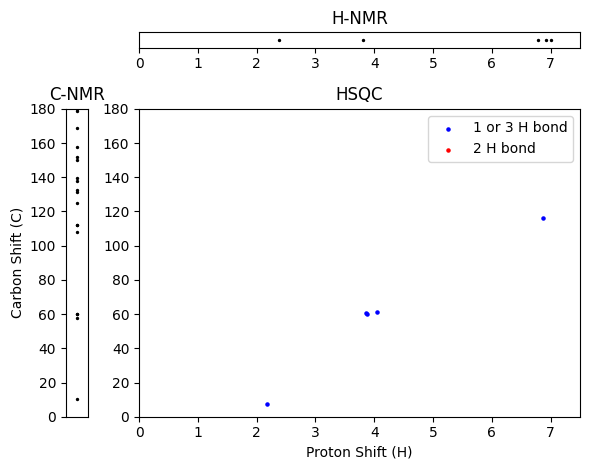

Prediction's cosine similarity to ground truth:  0.9184025526046753
Chemical name 5-Hydroxy-2-(4-hydroxyphenyl)-3,7,8-trimethoxy-6-methyl-4H-1-benzopyran-4-one
Ground truth smiles COc1c(C)c(O)c2c(=O)c(OC)c(-c3ccc(O)cc3)oc2c1OC


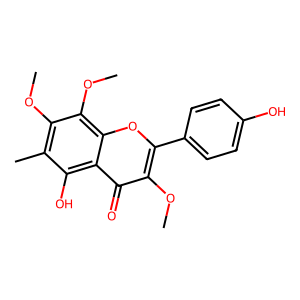

SMILES: COc1c(-c2ccc(O)cc2)oc2c(C)c(O)c(C)c(O)c2c1=O
Name 6,8-Di-C-Methylkaempferol 3-Methyl Ether


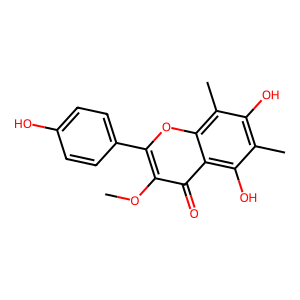

____________________incorrect retival #13________________________
Ground Truth NMR


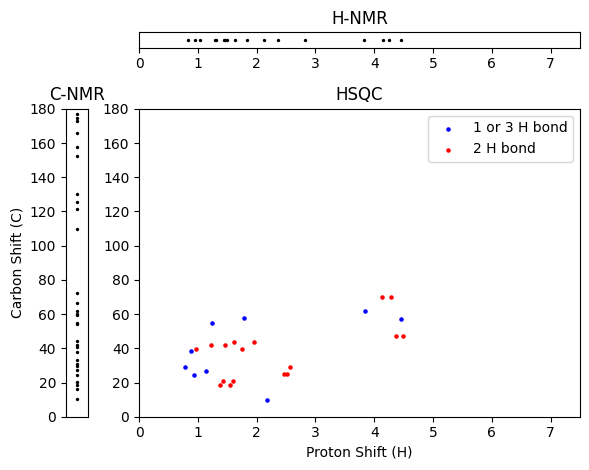

Prediction's cosine similarity to ground truth:  0.8206863403320312
Chemical name 139590810
Ground truth smiles COc1c(C)c(OCC2C(C)(O)CCC3C(C)(C)CCCC32C)c2c(c1C(=O)O)C(=O)N(C(CCC(=O)O)C(=O)O)C2


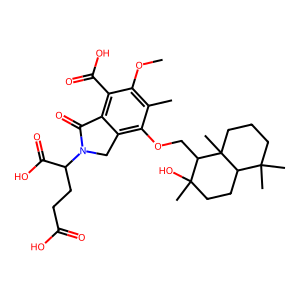

SMILES: COc1c(C)c(OCC2C(C)(O)CCC3C(C)(C)CCCC32C)c2c(c1C(=O)O)CN(C(CCC(=O)O)C(=O)O)C2=O
Name 2-{4-carboxy-7-[(2-hydroxy-2,5,5,8a-tetramethyl-hexahydro-1h-naphthalen-1-yl)methoxy]-5-methoxy-6-methyl-1-oxo-3h-isoindol-2-yl}pentanedioic acid


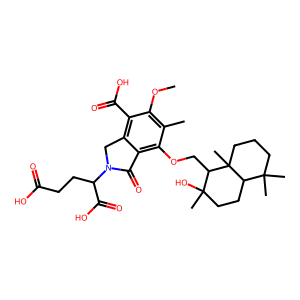

____________________incorrect retival #14________________________
Ground Truth NMR


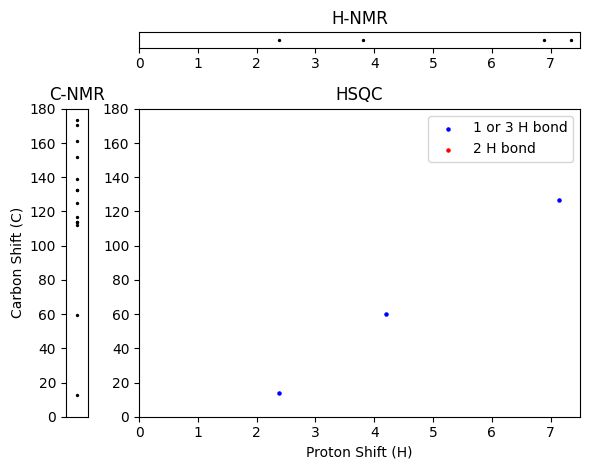

Prediction's cosine similarity to ground truth:  0.8722810745239258
Chemical name Marcanine D
Ground truth smiles COc1c(C)c2c([nH]c1=O)C(=O)c1cccc(O)c1C2=O


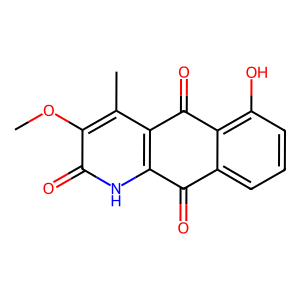

SMILES: COc1c(C)c(O)cc2c1C(=O)c1cccc(O)c1C2=O
Name 3,5-dihydroxy-1-methoxy-2-methylanthracene-9,10-dione


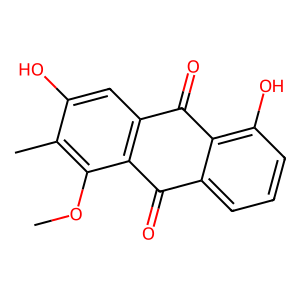

____________________incorrect retival #15________________________
Ground Truth NMR


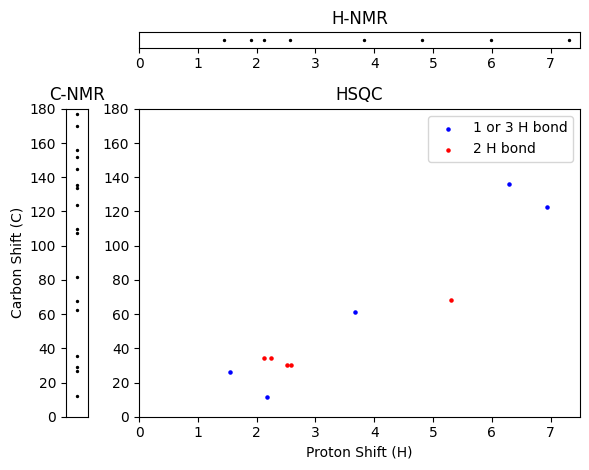

Prediction's cosine similarity to ground truth:  0.7411263585090637
Chemical name (3′S)-(E)-7-hydroxy-5-methoxy-4-methyl-6-(2-(2-methyl-5-oxotetrahydrofuran-2-yl)vinyl) isobenzofuran-1(3H)-one
Ground truth smiles COc1c(C)c2c(c(O)c1C=CC1(C)CCC(=O)O1)C(=O)OC2


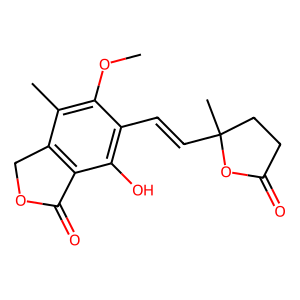

SMILES: COc1c(C)c2c(c3c1C=CC(C)(CCC(=O)O)O3)C(=O)OC2
Name Mycochromenic acid


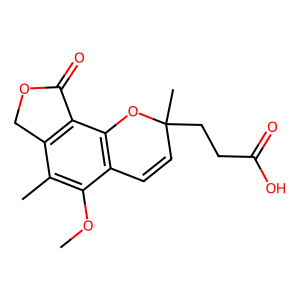

____________________incorrect retival #16________________________
Ground Truth NMR


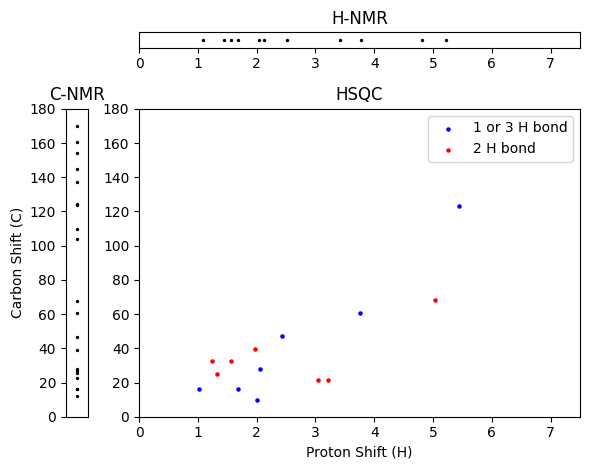

Prediction's cosine similarity to ground truth:  0.8658089637756348
Chemical name F01-1358B
Ground truth smiles COc1c(C)c2c(c(O)c1CC=C(C)CCCC(C)C(C)=O)C(=O)OC2


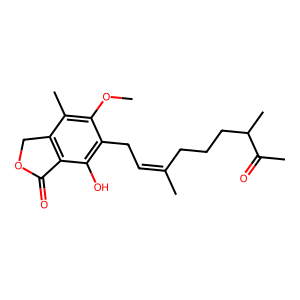

SMILES: COc1c(C)c2c(c(O)c1CC=C(C)CCCC(C)C(=O)O)C(=O)OC2
Name SCHEMBL4187939


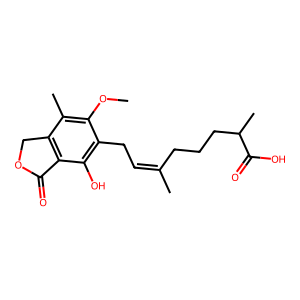

____________________incorrect retival #17________________________
Ground Truth NMR


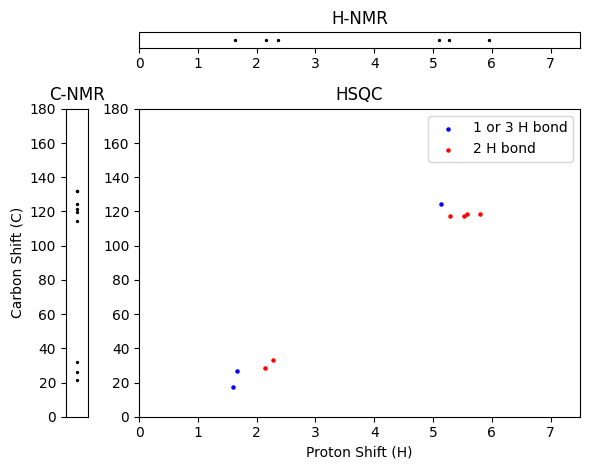

Prediction's cosine similarity to ground truth:  0.8634744882583618
Chemical name 7-bromomyrcene
Ground truth smiles C=C(Br)C(=C)CCC=C(C)C


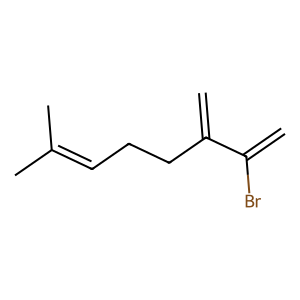

SMILES: C=C(Cl)C(=C)CCC=C(C)C
Name 7-chloromyrcene


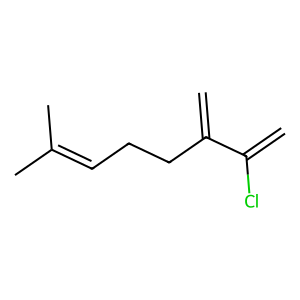

____________________incorrect retival #18________________________
Ground Truth NMR


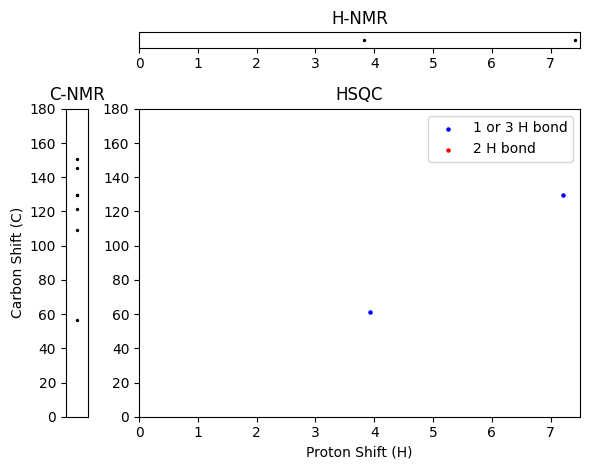

Prediction's cosine similarity to ground truth:  0.7090547680854797
Chemical name 2,4,6-trichloro-3-methoxyphenol
Ground truth smiles COc1c(Cl)cc(Cl)c(O)c1Cl


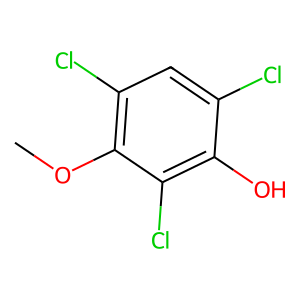

SMILES: COc1ccc(OC)cc1
Name 1,4-Dimethoxybenzene


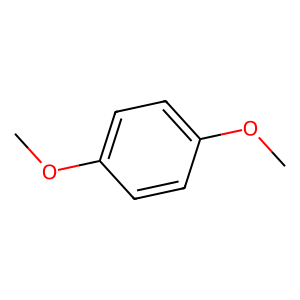

____________________incorrect retival #19________________________
Ground Truth NMR


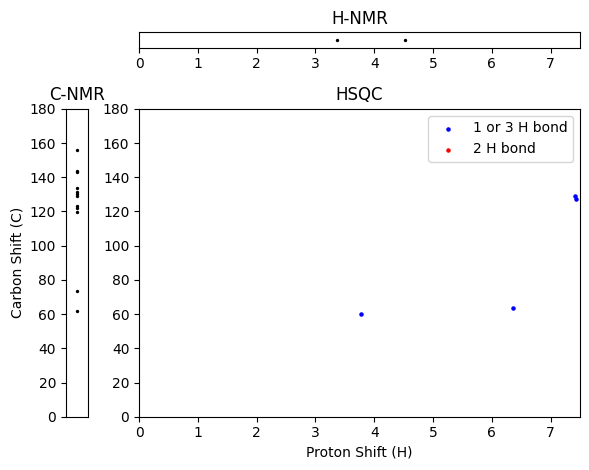

Prediction's cosine similarity to ground truth:  0.5593023896217346
Chemical name Pyrrolomycin H
Ground truth smiles COc1c(Cl)cc(Cl)cc1C(O)c1[nH]c(Cl)c(Cl)c1[N+](=O)[O-]


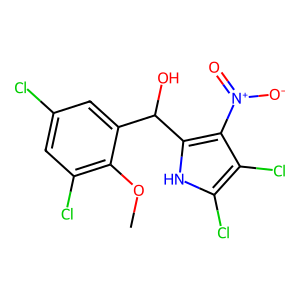

SMILES: COc1cc(Cl)c(O)c(Cl)c1
Name 2,6-dichloro-4-methoxyphenol


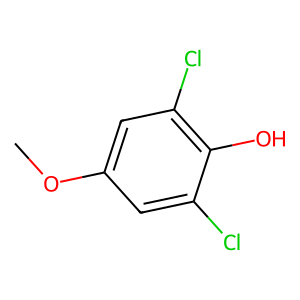

____________________incorrect retival #20________________________
Ground Truth NMR


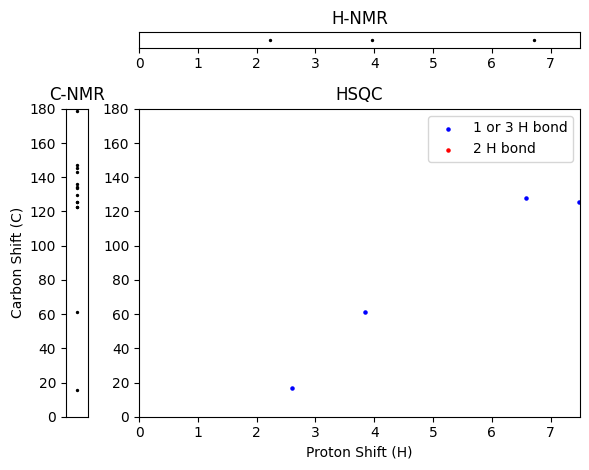

Prediction's cosine similarity to ground truth:  0.6848731637001038
Chemical name hallachrome
Ground truth smiles COc1c(O)c(C)cc2cc3c(cc12)C(=O)C(=O)C=C3


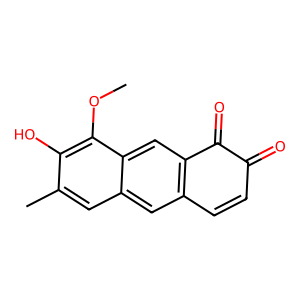

SMILES: COc1c(C)ccc2c1C(=O)c1ccccc1C2=O
Name 1-Methoxy-2-Methyl-Anthraquinone


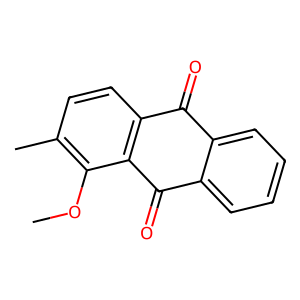

____________________incorrect retival #21________________________
Ground Truth NMR


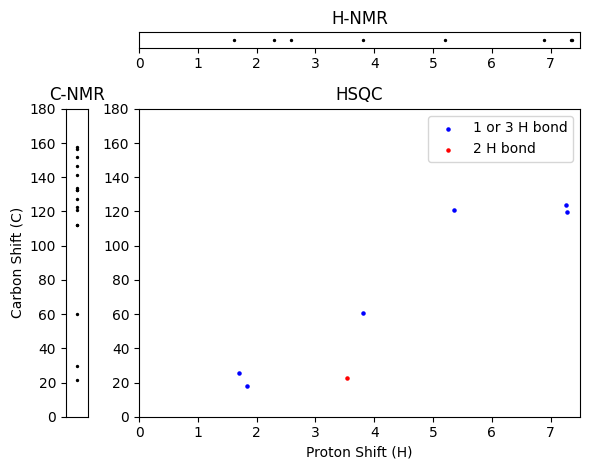

Prediction's cosine similarity to ground truth:  0.9370497465133667
Chemical name 937784-91-3
Ground truth smiles COc1c(O)c(O)c2c(=O)c3cccc(O)c3oc2c1CC=C(C)C


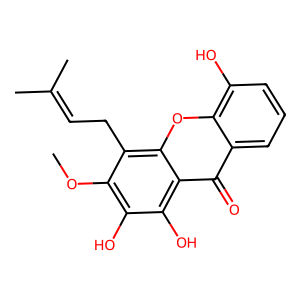

SMILES: COc1c(CC=C(C)C)c(O)c2c(=O)c3cccc(O)c3oc2c1CC=C(C)C
Name Cudraxanthone G


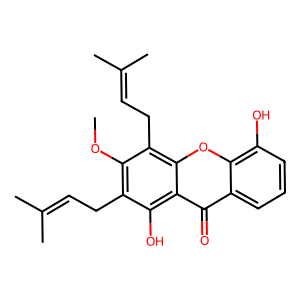

____________________incorrect retival #22________________________
Ground Truth NMR


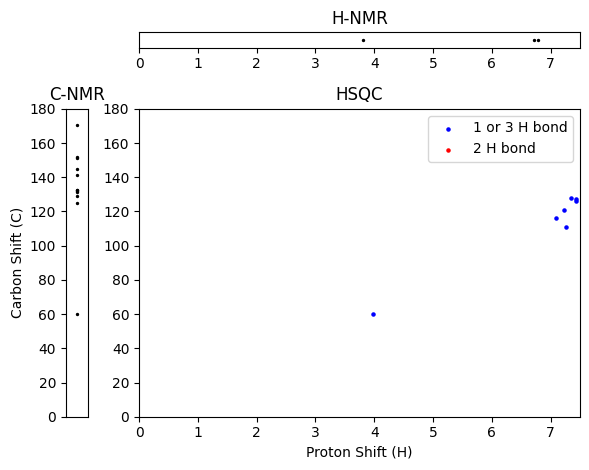

Prediction's cosine similarity to ground truth:  0.8157259225845337
Chemical name Fimbriol B
Ground truth smiles COc1c(O)c(O)cc2ccc3cccc(O)c3c12


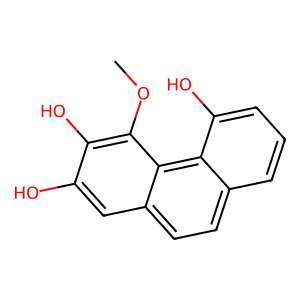

SMILES: COc1c(O)c(-c2ccccc2)cc(O)c1-c1ccccc1
Name 3-Methoxy-2,5-Diphenylbenzene-1,4-Diol


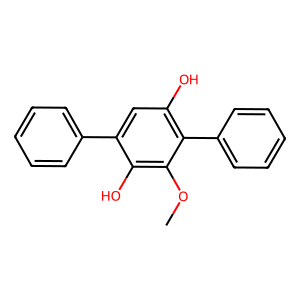

____________________incorrect retival #23________________________
Ground Truth NMR


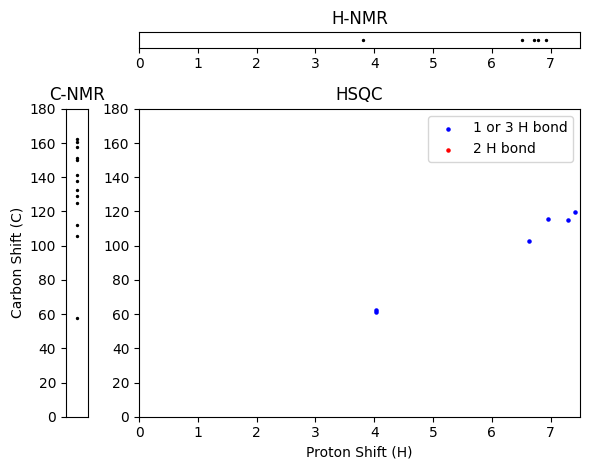

Prediction's cosine similarity to ground truth:  0.948051929473877
Chemical name NCGC00384491-01!2-(3,4-dihydroxyphenyl)-5,7-dihydroxy-6,8-dimethoxychromen-4-one
Ground truth smiles COc1c(O)c(OC)c2oc(-c3ccc(O)c(O)c3)cc(=O)c2c1O


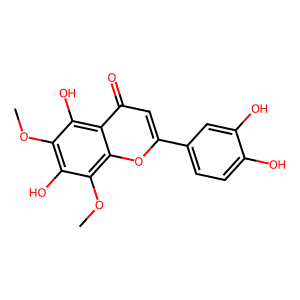

SMILES: COc1c(OC)c(O)c2c(=O)cc(-c3ccc(O)c(O)c3)oc2c1OC
Name Sideritiflavone


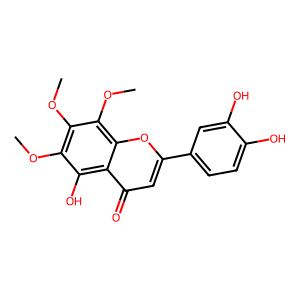

____________________incorrect retival #24________________________
Ground Truth NMR


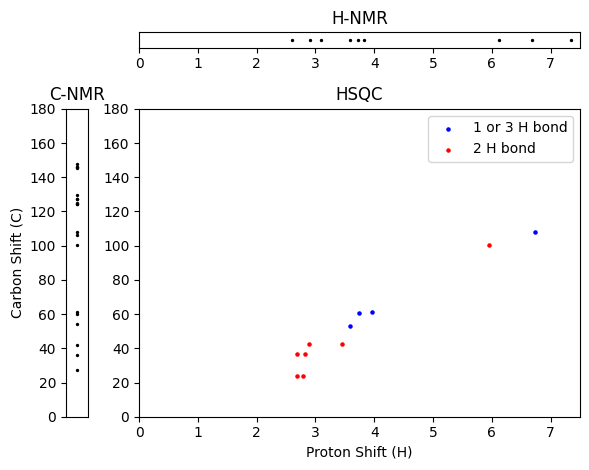

Prediction's cosine similarity to ground truth:  0.8169565796852112
Chemical name CHEBI:70640
Ground truth smiles COc1c(O)c2c3c(c1OC)-c1cc4c(cc1CC3NCC2)OCO4


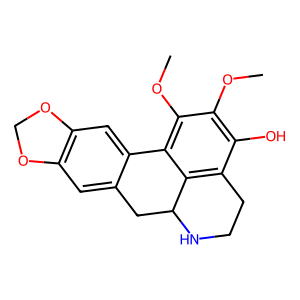

SMILES: COc1c2c3c(c(OC)c1OC)-c1cc4c(cc1CC3NCC2)OCO4
Name (+)-Norphoebine


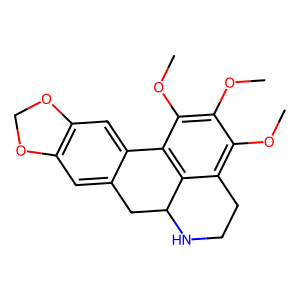

____________________incorrect retival #25________________________
Ground Truth NMR


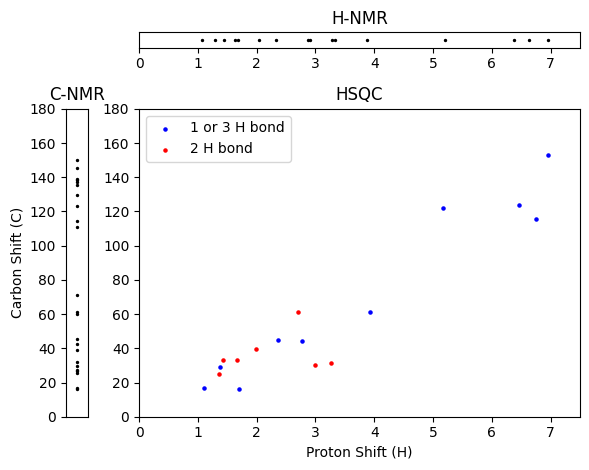

Prediction's cosine similarity to ground truth:  0.7539567947387695
Chemical name neoaplaminone
Ground truth smiles COc1c(O)cc(CC=C(C)CCCC(C)C(=O)C=CC(C)(C)O)c(CCN(C)C)c1Br


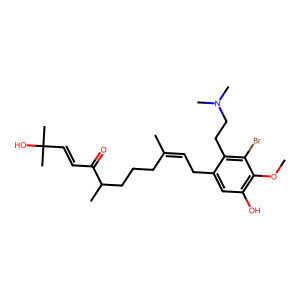

SMILES: COc1c(C)cc(O)cc1CC=C(C)CC(=O)C=C(C)CCCC(C)C(=O)C=CC(C)(C)O
Name amentadione-1'-methyl ether


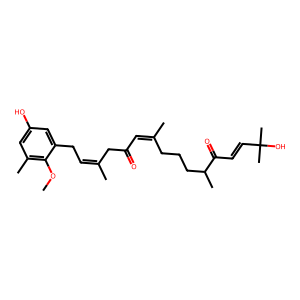

____________________incorrect retival #26________________________
Ground Truth NMR


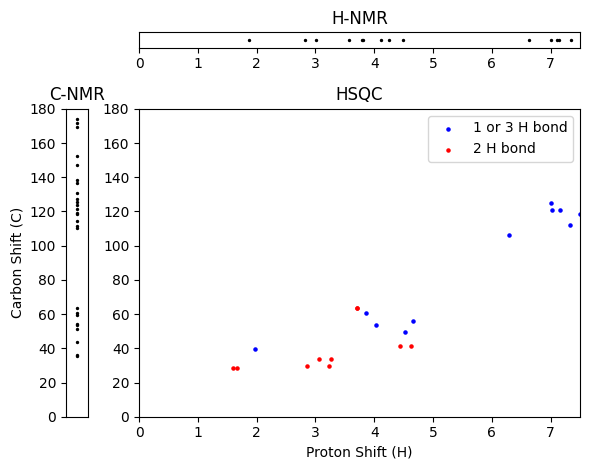

Prediction's cosine similarity to ground truth:  0.7436612248420715
Chemical name TMC-2A
Ground truth smiles COc1c(O)cc2c(c1O)CN(C(=O)C(N)Cc1c[nH]c3ccccc13)C(C(=O)NC(CC(CO)CO)C(=O)O)C2


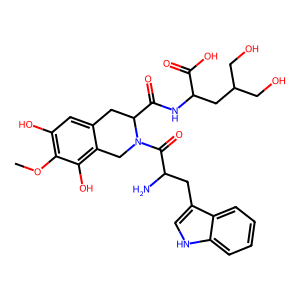

SMILES: COc1c(O)cc2c(c1O)CN1C(=O)C(Cc3c[nH]c4ccccc34)NC(=O)C1C2
Name 7,9-dihydroxy-3-(1H-indol-3-ylmethyl)-8-methoxy-2,3,11,11a-tetrahydro-6H-pyrazino[1,2-b]isoquinoline-1,4-dione


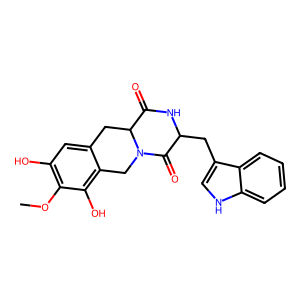

____________________incorrect retival #27________________________
Ground Truth NMR


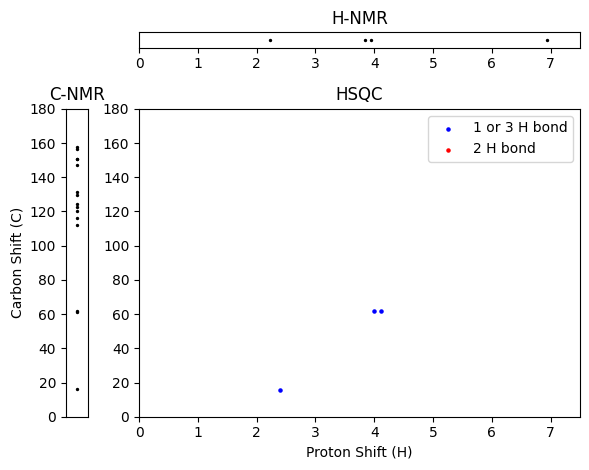

Prediction's cosine similarity to ground truth:  0.8791916370391846
Chemical name 1,2,6-Trihydroxy-7,8-Dimethoxy-3-Methylanthraquinone
Ground truth smiles COc1c(O)cc2c(c1OC)C(=O)c1c(cc(C)c(O)c1O)C2=O


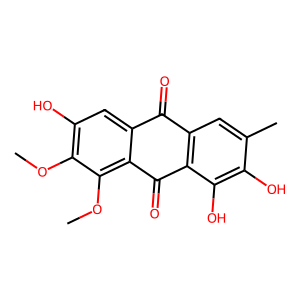

SMILES: COc1c(O)cc2c(c1O)C(=O)c1c(cc(C)c(O)c1OC)C2=O
Name Aurantioobtusin


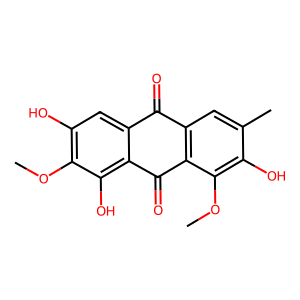

____________________incorrect retival #28________________________
Ground Truth NMR


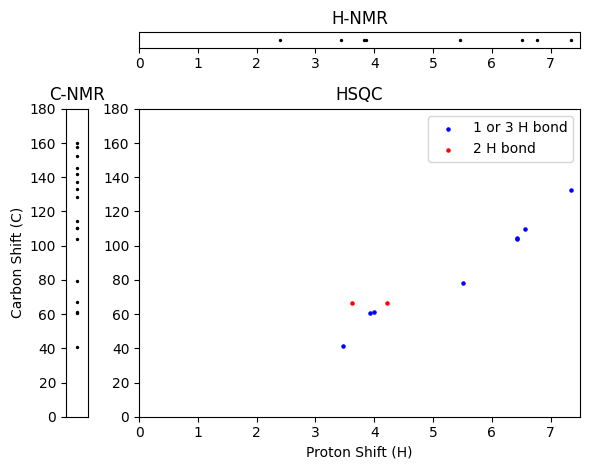

Prediction's cosine similarity to ground truth:  0.9059450626373291
Chemical name (6Ar,11Ar)-3,8-Dihydroxy-9,10-Dimethoxypterocarpan
Ground truth smiles COc1c(O)cc2c(c1OC)OC1c3ccc(O)cc3OCC21


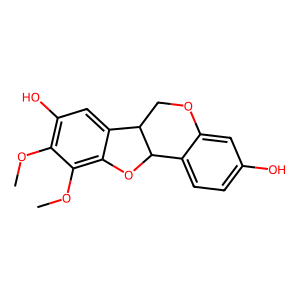

SMILES: COc1c(O)ccc2c1OC1c3ccc(O)cc3OCC21
Name (-)-Nissolin


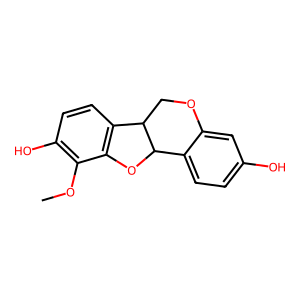

____________________incorrect retival #29________________________
Ground Truth NMR


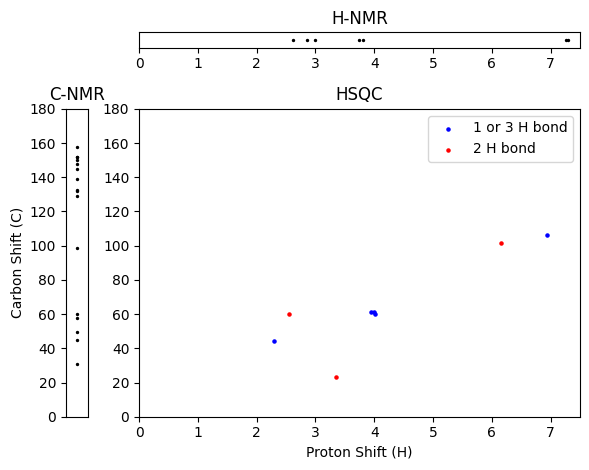

Prediction's cosine similarity to ground truth:  0.8486250638961792
Chemical name 111537-36-1
Ground truth smiles COc1c(OC)c(OC)c2c(ccc3cc4c(cc32)OCO4)c1CCN(C)C


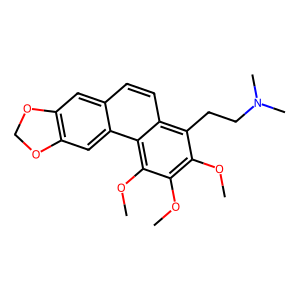

SMILES: COc1cc(CCN(C)C)c2ccc3cc4c(cc3c2c1OC)OCO4
Name Thalicthuberinec


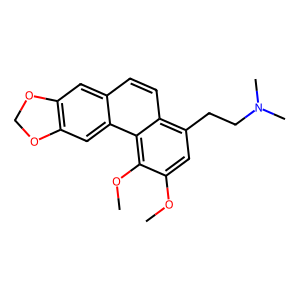

____________________incorrect retival #30________________________
Ground Truth NMR


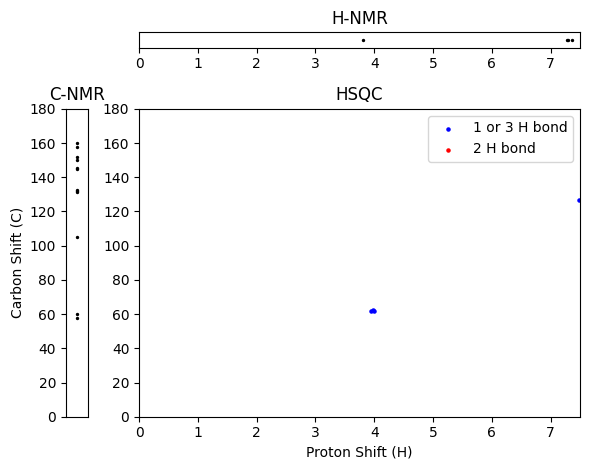

Prediction's cosine similarity to ground truth:  0.8450003266334534
Chemical name 11958181
Ground truth smiles COc1c(OC)c(OC)c2c3c(cc4ccccc42)NC(=O)C(=O)c13


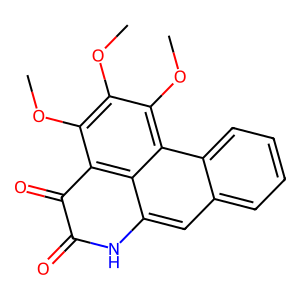

SMILES: COc1c(OC)c(OC)c2c3c(cc4ccccc42)NC(=O)c13
Name Piperolactam C


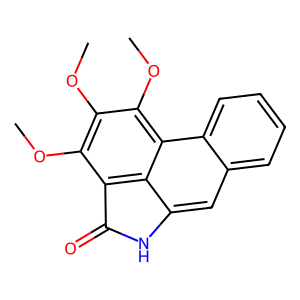

____________________incorrect retival #31________________________
Ground Truth NMR


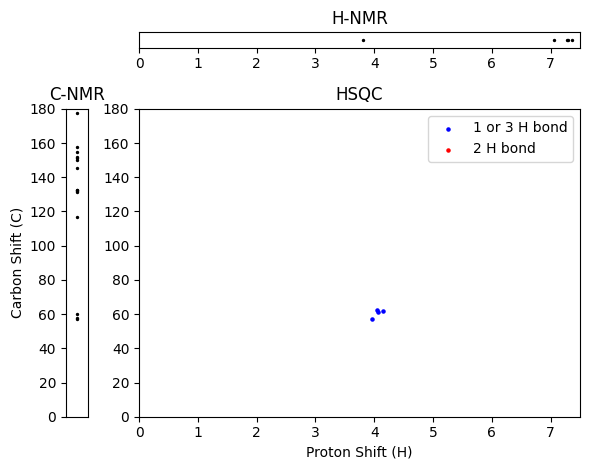

Prediction's cosine similarity to ground truth:  0.7887194752693176
Chemical name Chemspider_Imenine
Ground truth smiles COc1c(OC)c2c3c(ncc(OC)c3c1OC)C(=O)c1ccccc1-2


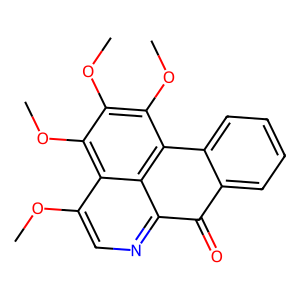

SMILES: COc1cc2c(c(OC)c1OC)C(=O)c1ccccc1C2=O
Name 1,2,3-trimethoxyanthracene-9,10-dione


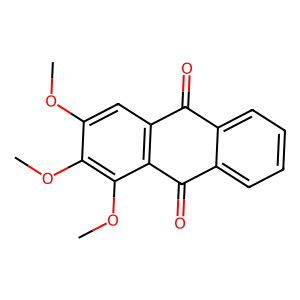

____________________incorrect retival #32________________________
Ground Truth NMR


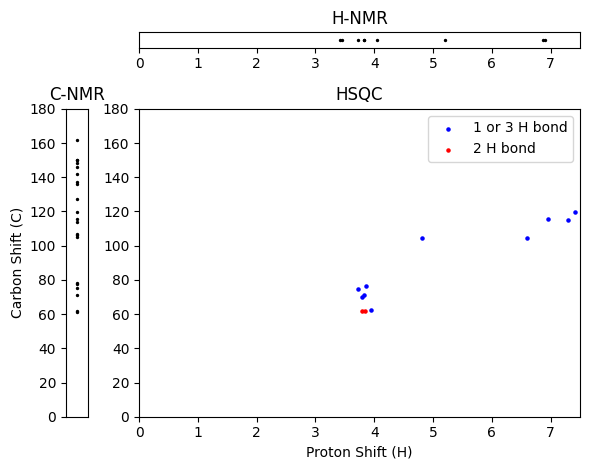

Prediction's cosine similarity to ground truth:  0.9688984751701355
Chemical name 151649-40-0
Ground truth smiles COc1c(OC2OC(CO)C(O)C(O)C2O)c(O)c(O)c2c(=O)cc(-c3ccc(O)c(O)c3)oc12


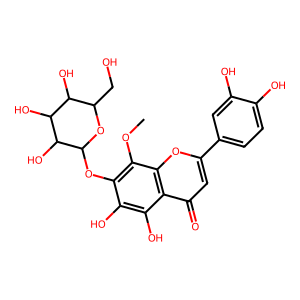

SMILES: COc1c(OC2OC(CO)C(O)C(O)C2O)c(O)c2c(=O)cc(-c3ccc(O)c(O)c3)oc2c1OC
Name 2-(3,4-dihydroxyphenyl)-5-hydroxy-7,8-dimethoxy-6-{[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}chromen-4-one


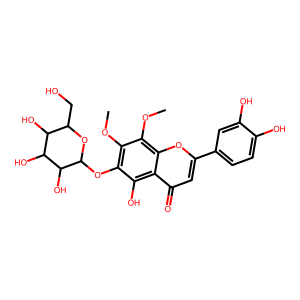

____________________incorrect retival #33________________________
Ground Truth NMR


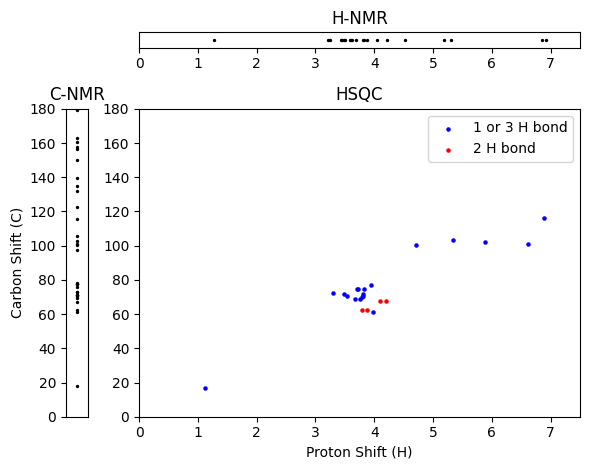

Prediction's cosine similarity to ground truth:  0.9655243754386902
Chemical name 95262-51-4
Ground truth smiles COc1c(OC2OC(COC3OC(C)C(O)C(O)C3O)C(O)C(O)C2O)cc(O)c2c(=O)c(OC3OC(CO)C(O)C(O)C3O)c(-c3ccc(O)cc3)oc12


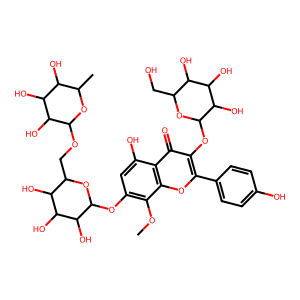

SMILES: COc1c(OC2OC(CO)C(O)C(O)C2O)cc(O)c2c(=O)c(OC3OC(COC4OC(C)C(O)C(O)C4O)C(O)C(O)C3O)c(-c3ccc(O)cc3)oc12
Name 44259929


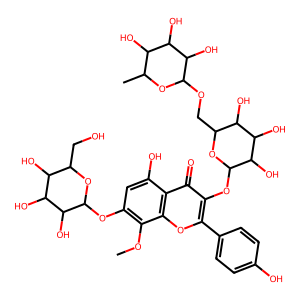

____________________incorrect retival #34________________________
Ground Truth NMR


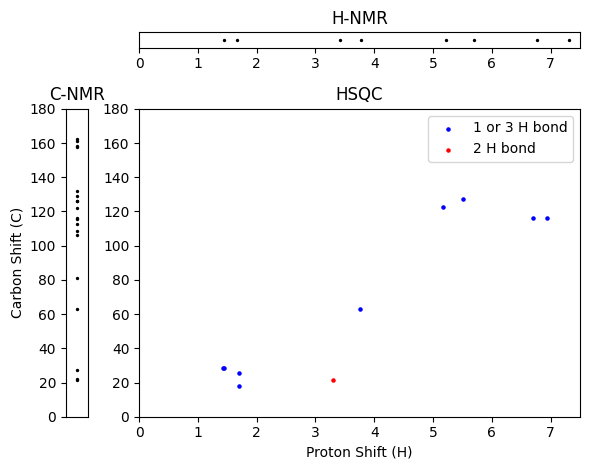

Prediction's cosine similarity to ground truth:  0.9195132255554199
Chemical name Derrisdione A
Ground truth smiles COc1c2c(c(CC=C(C)C)c(O)c1C(=O)C(=O)c1ccc(O)cc1)OC(C)(C)C=C2


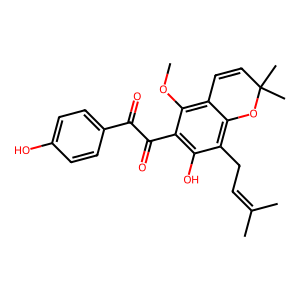

SMILES: COc1c2c(c(CC=C(C)C)c(O)c1C(=O)c1ccc(O)cc1)OC(C)(C)C=C2
Name 6-(4-hydroxybenzoyl)-5-methoxy-2,2-dimethyl-8-(3-methylbut-2-en-1-yl)chromen-7-ol


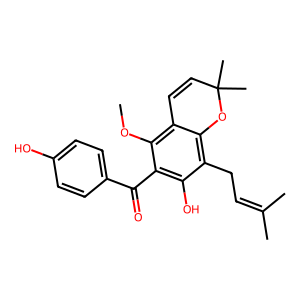

____________________incorrect retival #35________________________
Ground Truth NMR


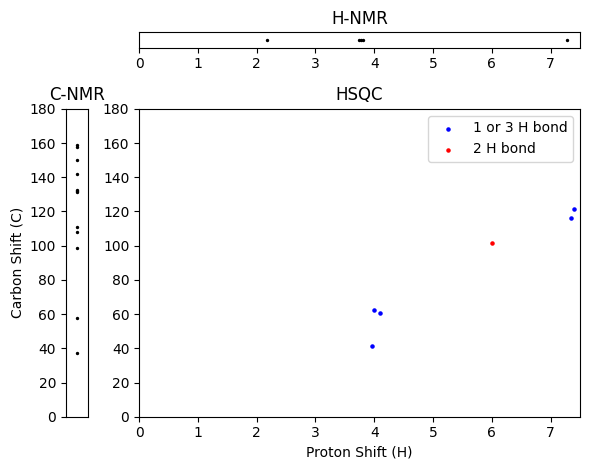

Prediction's cosine similarity to ground truth:  0.8707910180091858
Chemical name 4,5-Dimethoxy-11-Methyl-[1,3]Dioxolo[4,5-C]Acridin-6-One
Ground truth smiles COc1c2c(c3c(c1OC)c(=O)c1ccccc1n3C)OCO2


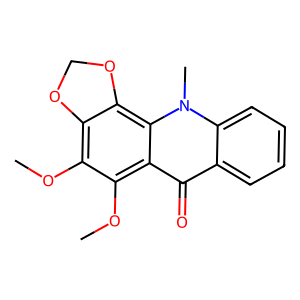

SMILES: COc1c2c(c(OC)c3c1c(=O)c1ccccc1n3C)OCO2
Name 4,11-Dimethoxy-5-Methyl-[1,3]Dioxolo[4,5-B]Acridin-10-One


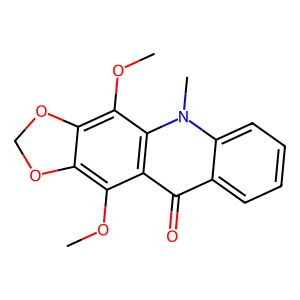

____________________incorrect retival #36________________________
Ground Truth NMR


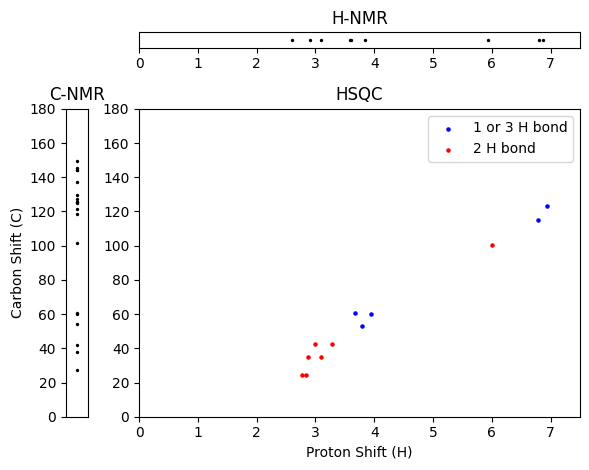

Prediction's cosine similarity to ground truth:  0.8646302223205566
Chemical name 15583-41-2
Ground truth smiles COc1c2c3c(c4c1OCO4)-c1c(ccc(O)c1OC)CC3NCC2


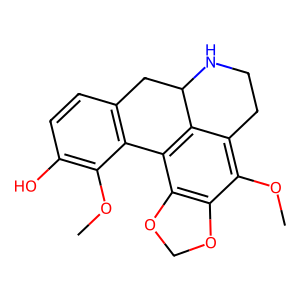

SMILES: COc1c(O)ccc2c1-c1c3c(cc4c1C(C2)NCC4)OCO3
Name 31520-97-5


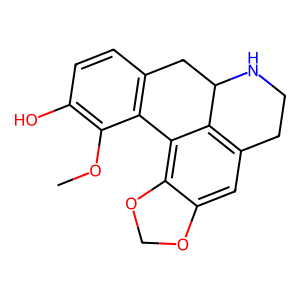

____________________incorrect retival #37________________________
Ground Truth NMR


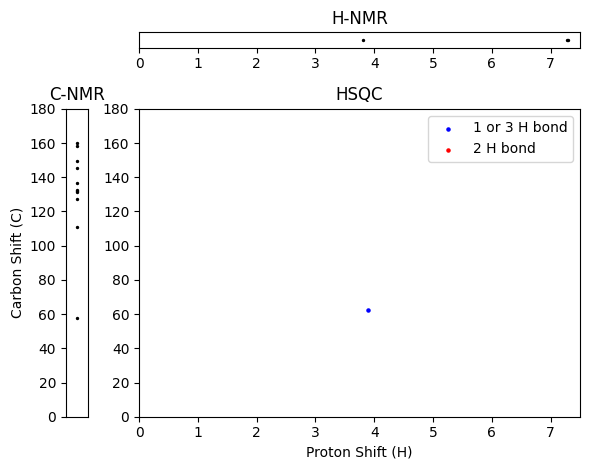

Prediction's cosine similarity to ground truth:  0.7529366612434387
Chemical name Hadranthine B
Ground truth smiles COc1c2c3c(ccnc3c3ccccc13)C(=O)C(=O)N2


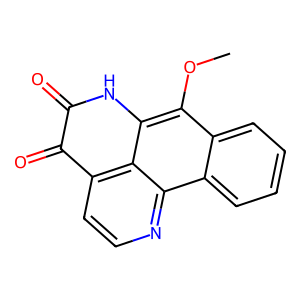

SMILES: COc1c(OC)c2c3c(nccc3c1OC)C(=O)c1ccccc1-2
Name Homomoschatoline


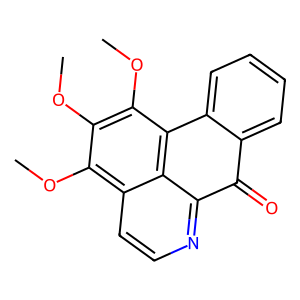

____________________incorrect retival #38________________________
Ground Truth NMR


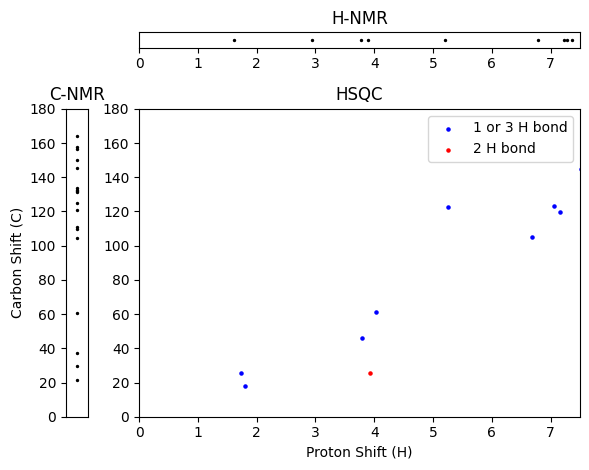

Prediction's cosine similarity to ground truth:  0.8510463833808899
Chemical name 10594882
Ground truth smiles COc1c2ccoc2c(CC=C(C)C)c2c1c(=O)c1cccc(O)c1n2C


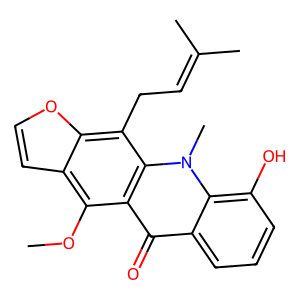

SMILES: COc1c(CC=C(C)C)c(O)c2c(=O)c3cccc(O)c3n(C)c2c1CC=C(C)C
Name NCGC00385825-01!1,5-dihydroxy-3-methoxy-10-methyl-2,4-bis(3-methylbut-2-enyl)acridin-9-one


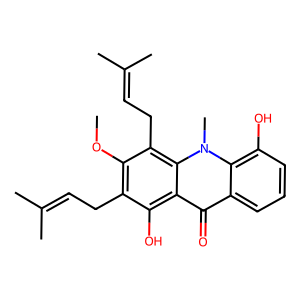

____________________incorrect retival #39________________________
Ground Truth NMR


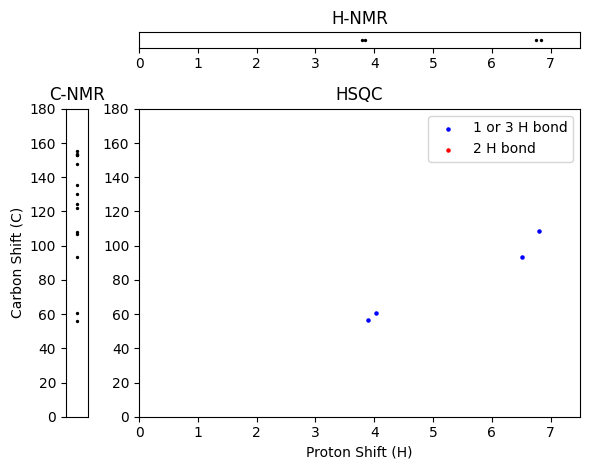

Prediction's cosine similarity to ground truth:  0.8988062143325806
Chemical name 73265447
Ground truth smiles COc1cc(-c2coc3cc(O)c(OC)c(O)c3c2=O)cc(OC)c1O


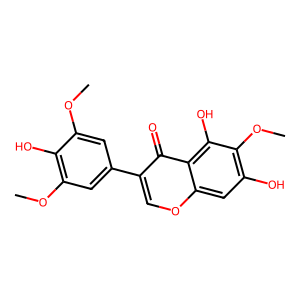

SMILES: COc1cc(-c2coc3cc(O)c(OC)c(O)c3c2=O)cc(O)c1OC
Name Irigenin


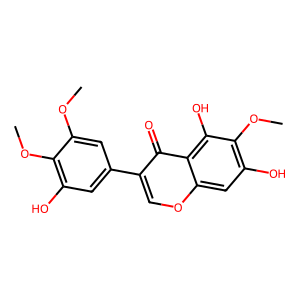

____________________incorrect retival #40________________________
Ground Truth NMR


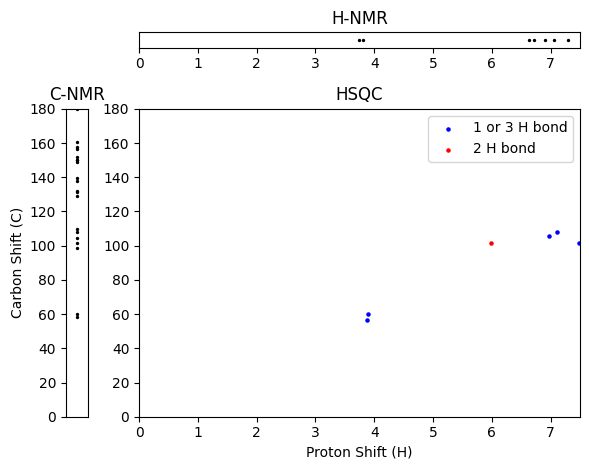

Prediction's cosine similarity to ground truth:  0.7959171533584595
Chemical name 60077-58-9
Ground truth smiles COc1cc(-c2oc3c(ccc4occc43)c(=O)c2OC)cc2c1OCO2


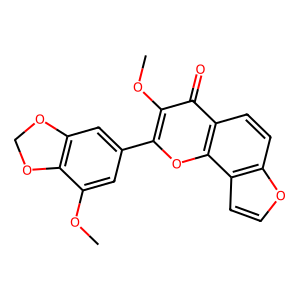

SMILES: COc1c(-c2ccc3c(c2)OCO3)oc2c(c(OC)c(OC)c3occc32)c1=O
Name 3,5,6-Trimethoxy-3',4'-methylene-dioxyfurano[2,3:7,8]flavone


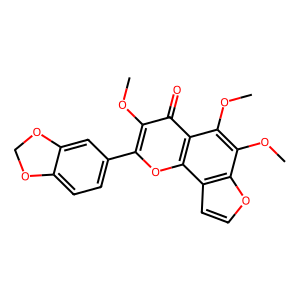

____________________incorrect retival #41________________________
Ground Truth NMR


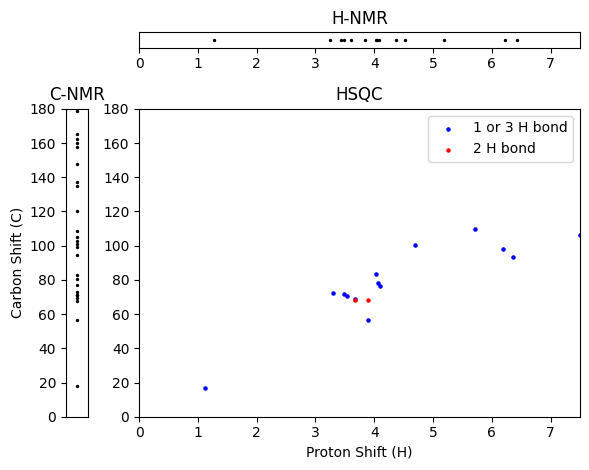

Prediction's cosine similarity to ground truth:  0.9685285687446594
Chemical name 44259500
Ground truth smiles COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2OC2OC(COC3OC(C)C(O)C(O)C3O)C(O)C2O)cc(OC)c1O


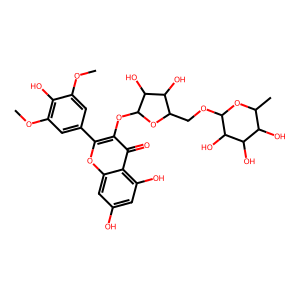

SMILES: COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2OC2OC(COC3OC(C)C(O)C(O)C3O)C(O)C(O)C2O)cc(OC)c1O
Name 44259501


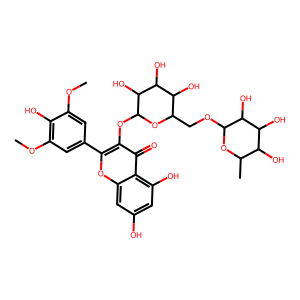

____________________incorrect retival #42________________________
Ground Truth NMR


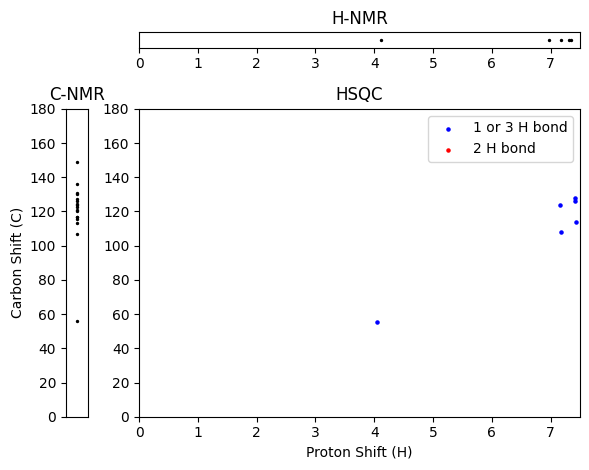

Prediction's cosine similarity to ground truth:  0.7937312722206116
Chemical name 3',5,5'-tribromo-7'-methyoxy-bi-1H-indol
Ground truth smiles COc1cc(Br)c(-c2c[nH]c3ccc(Br)cc23)c2c(Br)c[nH]c12


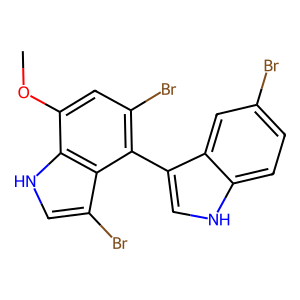

SMILES: COc1cc(Br)c(-c2c(Br)[nH]c3ccc(Br)cc23)c2c(Br)c[nH]c12
Name tetrabromo-7'-methyoxy-3,4'-bi-1H-indole


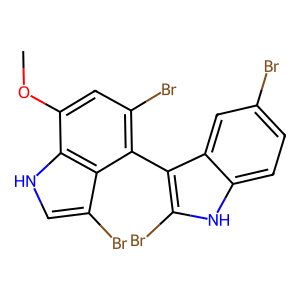

____________________incorrect retival #43________________________
Ground Truth NMR


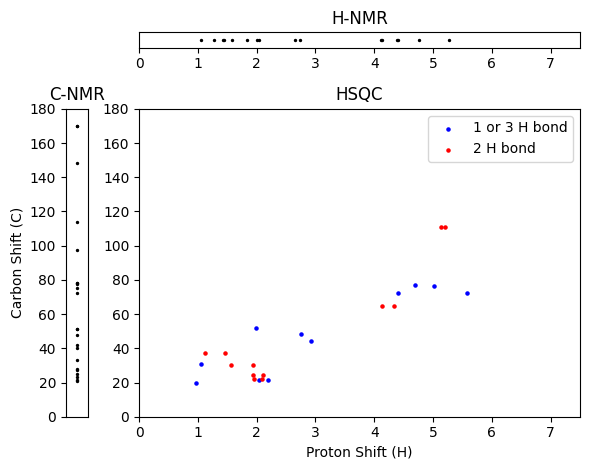

Prediction's cosine similarity to ground truth:  0.8690007328987122
Chemical name 150148-80-4
Ground truth smiles C=C1C2CCC3C45COC(O)(C(OC(C)=O)C4C(C)(C)CCC5OC(C)=O)C3(C1O)C2O


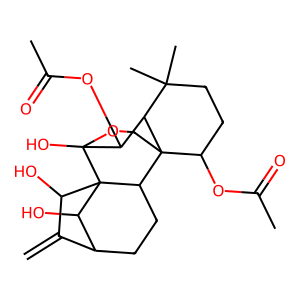

SMILES: C=C1C2CCC3C45COC(O)(C(O)C4C(C)(C)CCC5OC(C)=O)C3(C1O)C2O
Name Lasiokaurinol


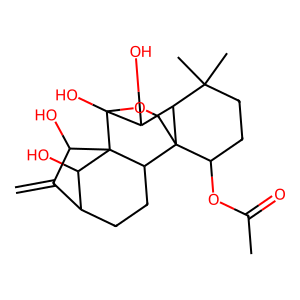

____________________incorrect retival #44________________________
Ground Truth NMR


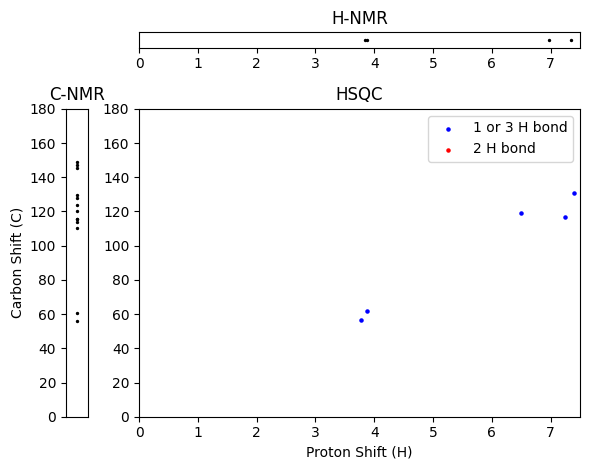

Prediction's cosine similarity to ground truth:  0.7567874193191528
Chemical name pentabromo-2,2'-oxydiphenol 1,1'-dimethy
Ground truth smiles COc1cc(Br)c(Br)c(Br)c1Oc1cc(Br)cc(Br)c1OC


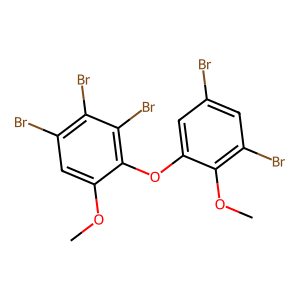

SMILES: COc1cc(Br)cc(Br)c1Oc1cc(Br)cc(Br)c1O
Name dibromo-2-(methoxy-dibromophenoxy)phenol


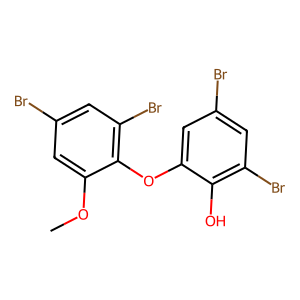

____________________incorrect retival #45________________________
Ground Truth NMR


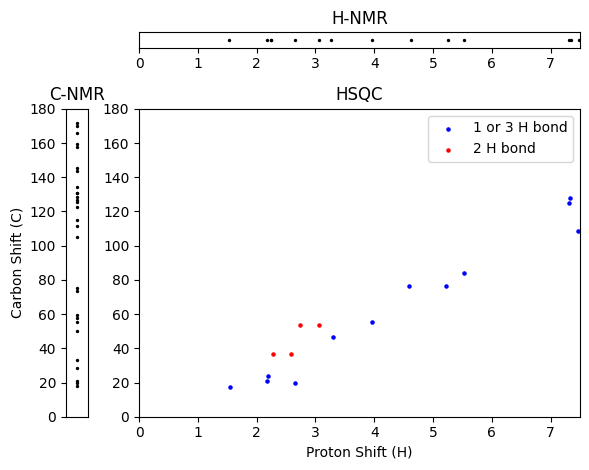

Prediction's cosine similarity to ground truth:  0.6537862420082092
Chemical name CARZINOPHILIN
Ground truth smiles COc1cc(C(=O)OC(C(=O)NC(C(=O)NC(=CO)C(C)=O)=C2C(OC(C)=O)C(O)C3CN23)C2(C)CO2)c2cccc(C)c2c1


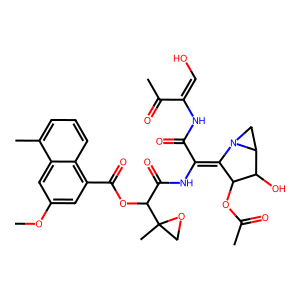

SMILES: COc1c2c(nc3ccccc13)OC(C)(C)C(OC(C)=O)C2
Name O-Acetylgeibalansine


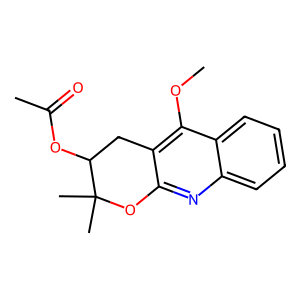

____________________incorrect retival #46________________________
Ground Truth NMR


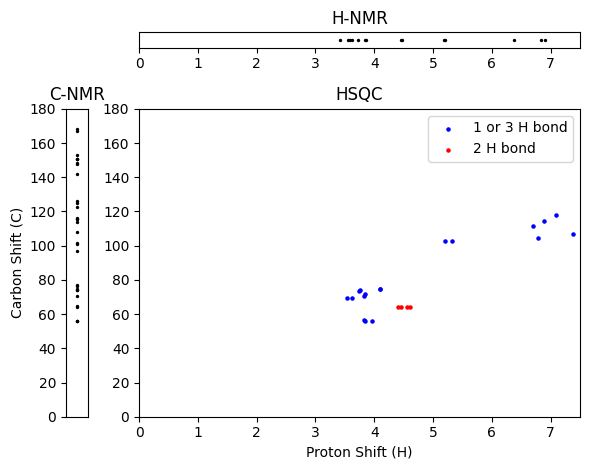

Prediction's cosine similarity to ground truth:  0.9333829879760742
Chemical name 166604-04-2
Ground truth smiles COc1cc(C(=O)OCC2OC(Oc3ccc(OC4OC(COC(=O)c5cc(OC)c(O)c(OC)c5)C(O)C(O)C4O)cc3OC)C(O)C(O)C2O)ccc1O


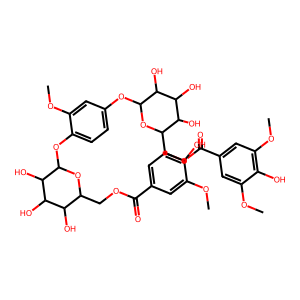

SMILES: COc1cc(C(=O)OCC2OC(Oc3ccc(OC4OC(COC(=O)c5ccc(O)c(OC)c5)C(O)C(O)C4O)c(OC)c3)C(O)C(O)C2O)ccc1O
Name [(2r,3s,4s,5r,6s)-3,4,5-trihydroxy-6-(3-methoxy-4-{[(2s,3r,4s,5s,6r)-3,4,5-trihydroxy-6-[(4-hydroxy-3-methoxybenzoyloxy)methyl]oxan-2-yl]oxy}phenoxy)oxan-2-yl]methyl 4-hydroxy-3-methoxybenzoate


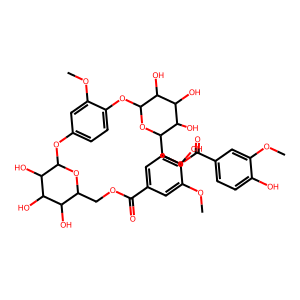

____________________incorrect retival #47________________________
Ground Truth NMR


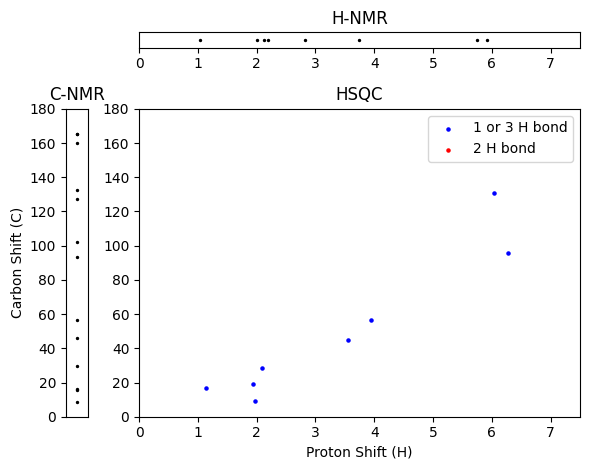

Prediction's cosine similarity to ground truth:  0.8105638027191162
Chemical name UNPD146135
Ground truth smiles COc1cc(C(C)=CC(C)C(C)=O)oc(=O)c1C


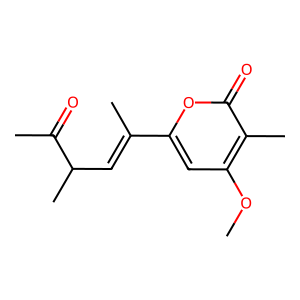

SMILES: COc1cc(C(C)=CC(C)C)oc(=O)c1C
Name aplysiopsene B


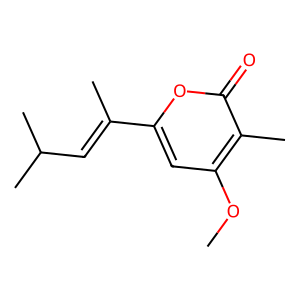

____________________incorrect retival #48________________________
Ground Truth NMR


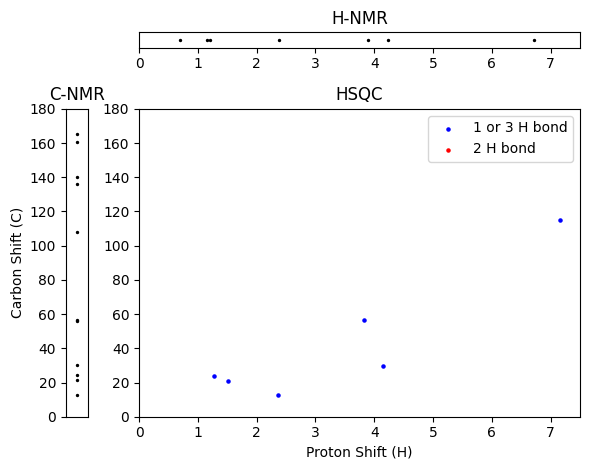

Prediction's cosine similarity to ground truth:  0.7735985517501831
Chemical name 6-methoxyprimnatriene-1,3-dione
Ground truth smiles COc1cc(C(C)C)c2c(c1C)C(=O)C(C)(C)C2=O


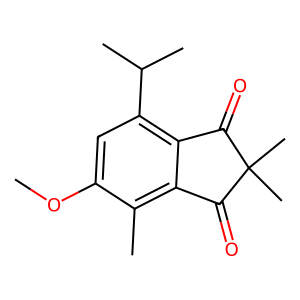

SMILES: COc1cc(C(C)C)c(OC)cc1C
Name Thymoquinol Dimethylether


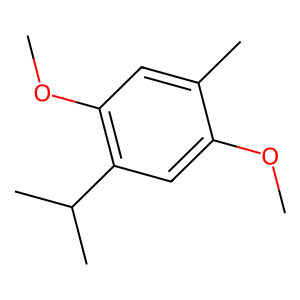

____________________incorrect retival #49________________________
Ground Truth NMR


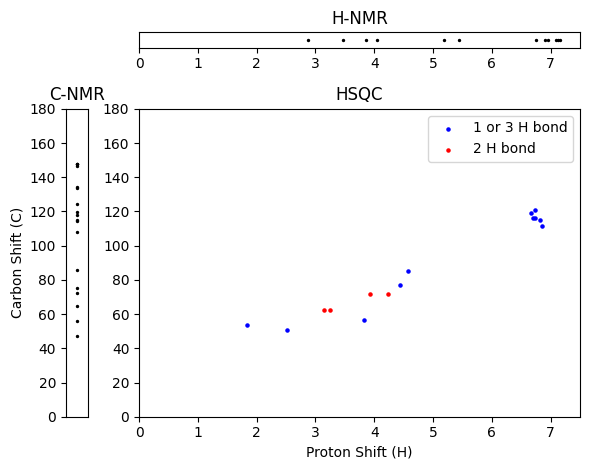

Prediction's cosine similarity to ground truth:  0.944735586643219
Chemical name (7R)-7-hydroxytaxiresinol
Ground truth smiles COc1cc(C(O)C2COC(c3ccc(O)c(O)c3)C2CO)ccc1O


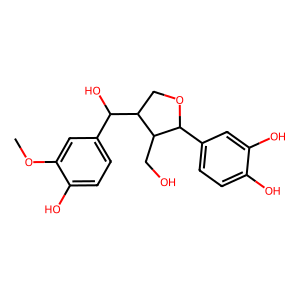

SMILES: COc1cc(C2OCC(C(O)c3ccc(O)c(O)c3)C2CO)ccc1O
Name 4-[(r)-hydroxy[(3s,4r,5s)-5-(4-hydroxy-3-methoxyphenyl)-4-(hydroxymethyl)oxolan-3-yl]methyl]benzene-1,2-diol


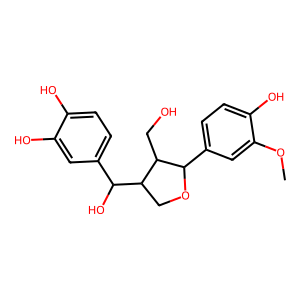

____________________incorrect retival #50________________________
Ground Truth NMR


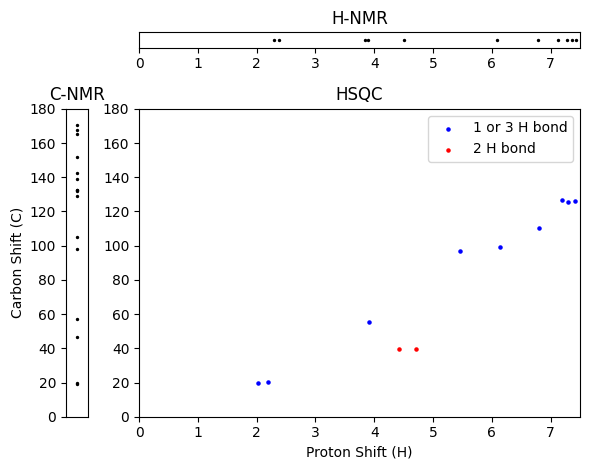

Prediction's cosine similarity to ground truth:  0.7443873286247253
Chemical name 56973-82-1
Ground truth smiles COc1cc(C)c(-c2c(O)cc(O)c3c2C=C(C)NC3)c2ccccc12


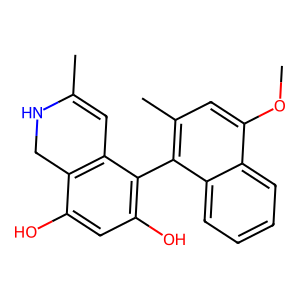

SMILES: COc1cccc2[nH]c3cc(O)c(C)cc3c12
Name UNPD110059


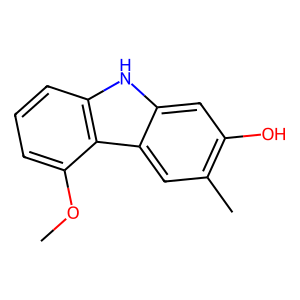

____________________incorrect retival #51________________________
Ground Truth NMR


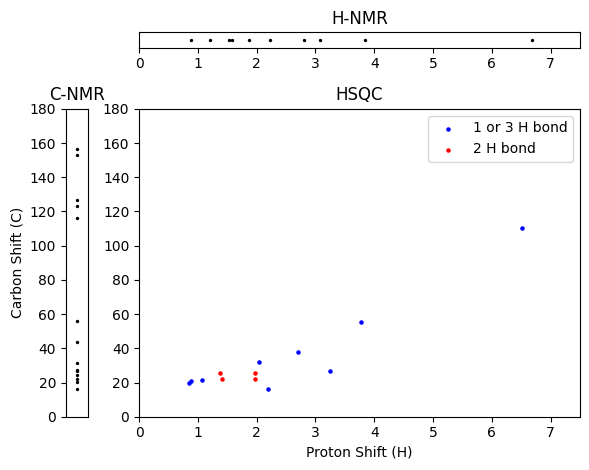

Prediction's cosine similarity to ground truth:  0.8315427899360657
Chemical name 5-hydroxy-8-methoxycalamenene
Ground truth smiles COc1cc(C)c(O)c2c1C(C)CCC2C(C)C


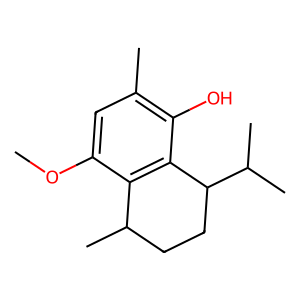

SMILES: COc1cc2c(cc1C)C(C)CCC2C(C)C
Name 1-isopropyl-7-methoxy-4,6-dimethyl-1,2,3,4-tetrahydronaphthalene


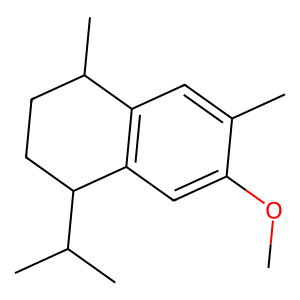

____________________incorrect retival #52________________________
Ground Truth NMR


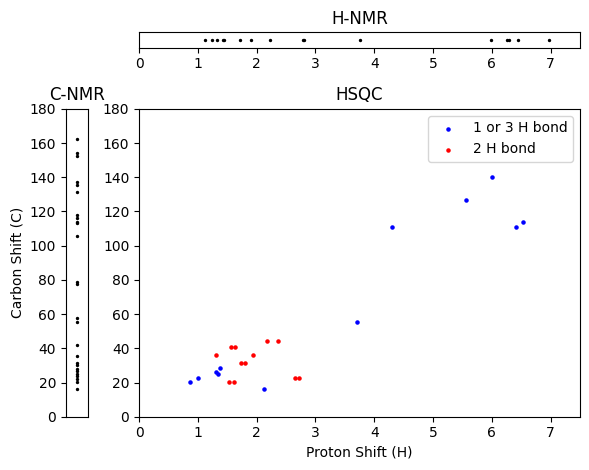

Prediction's cosine similarity to ground truth:  0.7503377795219421
Chemical name cystoketal chromane
Ground truth smiles COc1cc(C)c2c(c1)CCC(C)(CC1=CC3(C)CCCC3(C)C3(C=CC(C)(C)O3)O1)O2


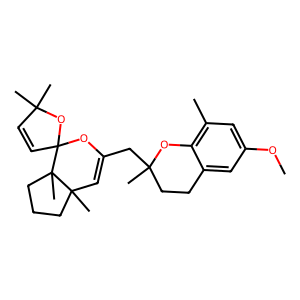

SMILES: COc1cc(C)c(OC)c(CC=C(C)CC2=CC3(C)CCCC3(C)C3(C=CC(C)(C)O3)O2)c1
Name (7S,11S,12S)-1'-methoxycystoketal


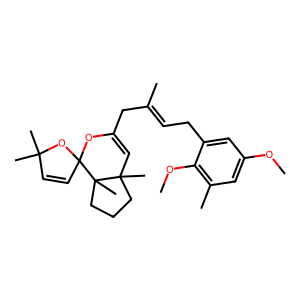

____________________incorrect retival #53________________________
Ground Truth NMR


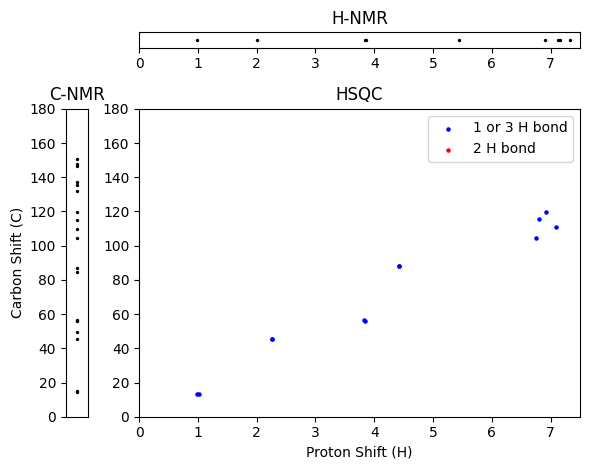

Prediction's cosine similarity to ground truth:  0.9429206252098083
Chemical name (-)-(7S,7'R,8S,8'R)-4,4'-dihydroxy-3,3',5'-trimethoxy-7,7'-epoxylignan
Ground truth smiles COc1cc(C2OC(c3cc(OC)c(O)c(OC)c3)C(C)C2C)ccc1O


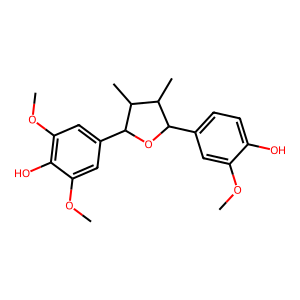

SMILES: COc1cc(C2OC(c3ccc(O)c(OC)c3)C(C)C2C)ccc1O
Name (-)-Fragransin A2


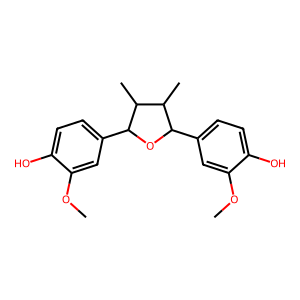

____________________incorrect retival #54________________________
Ground Truth NMR


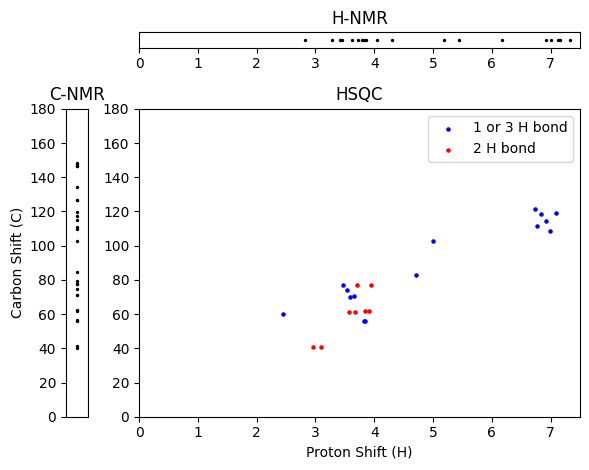

Prediction's cosine similarity to ground truth:  0.9465101361274719
Chemical name Olivil 4''-O-Beta-D-Glucopyranoside
Ground truth smiles COc1cc(C2OCC(O)(Cc3ccc(OC4OC(CO)C(O)C(O)C4O)c(OC)c3)C2CO)ccc1O


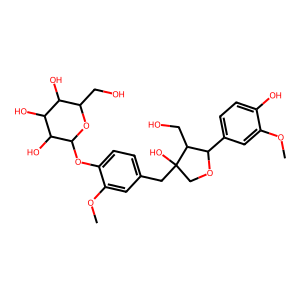

SMILES: COc1cc(CC2(O)COC(c3ccc(OC4OC(CO)C(O)C(O)C4O)c(OC)c3)C2CO)ccc1O
Name Olivil 4-O-Beta-D-Glucopyranoside


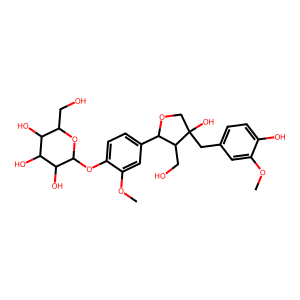

____________________incorrect retival #55________________________
Ground Truth NMR


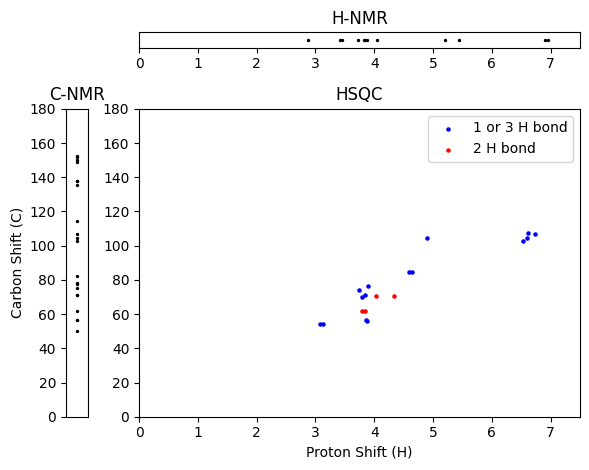

Prediction's cosine similarity to ground truth:  0.9578415155410767
Chemical name 190655-18-6
Ground truth smiles COc1cc(C2OCC3C(c4cc(O)c(OC5OC(CO)C(O)C(O)C5O)c(OC)c4)OCC23)cc(O)c1O


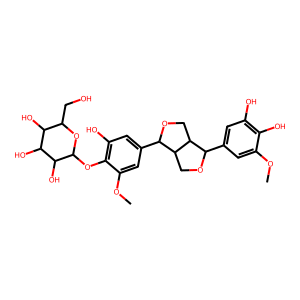

SMILES: COc1cc(C2OCC3C(c4cc(O)c(OC5OC(CO)C(O)C(O)C5O)c(OC)c4)OCC23)cc(OC)c1O
Name 2-{2-hydroxy-4-[4-(4-hydroxy-3,5-dimethoxyphenyl)-hexahydrofuro[3,4-c]furan-1-yl]-6-methoxyphenoxy}-6-(hydroxymethyl)oxane-3,4,5-triol


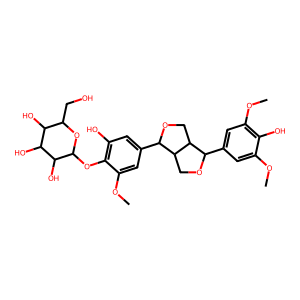

____________________incorrect retival #56________________________
Ground Truth NMR


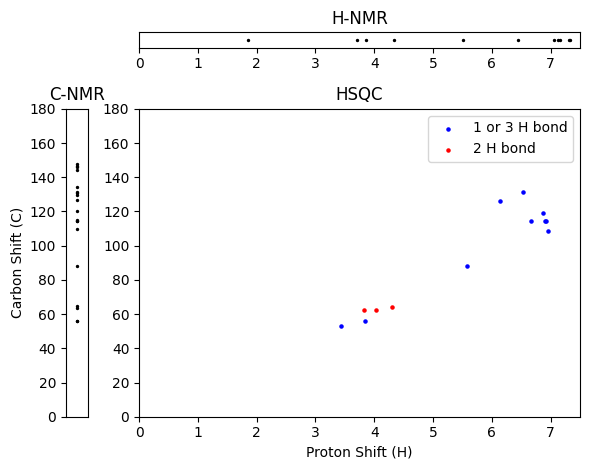

Prediction's cosine similarity to ground truth:  0.930046558380127
Chemical name 155759-04-9
Ground truth smiles COc1cc(C2Oc3c(O)cc(C=CCO)cc3C2CO)ccc1O


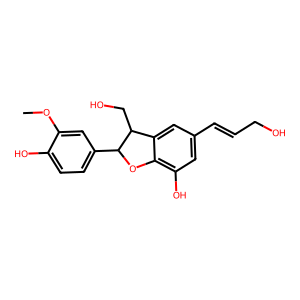

SMILES: COc1cc(C2Oc3c(OC)cc(C=CCO)cc3C2CO)ccc1O
Name Dehydroconiferyl Alcohol


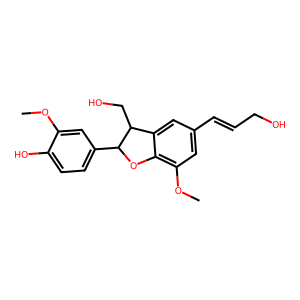

____________________incorrect retival #57________________________
Ground Truth NMR


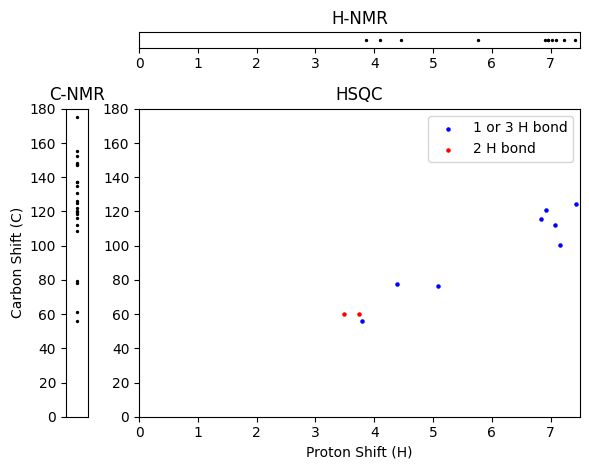

Prediction's cosine similarity to ground truth:  0.9345794916152954
Chemical name 2-demthylkielcorin
Ground truth smiles COc1cc(C2Oc3c(O)cc4c(=O)c5ccccc5oc4c3OC2CO)ccc1O


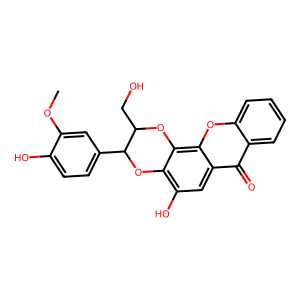

SMILES: COc1cc(C2Oc3c(OC)cc4c(=O)c5ccccc5oc4c3OC2CO)ccc1O
Name Kielcorin


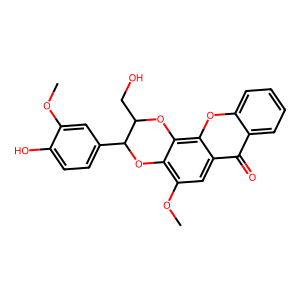

____________________incorrect retival #58________________________
Ground Truth NMR


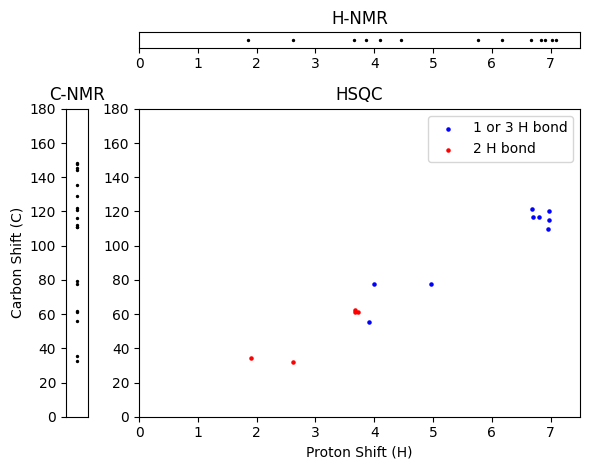

Prediction's cosine similarity to ground truth:  0.962976336479187
Chemical name (7S,8S)-Methoxy-3',7-Epoxy-8,4'-Oxyneoligna-4,9,9'-Triol
Ground truth smiles COc1cc(C2Oc3cc(CCCO)ccc3OC2CO)ccc1O


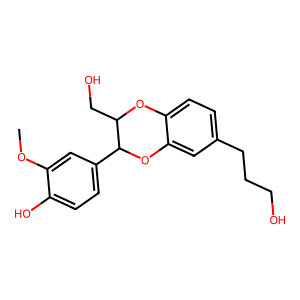

SMILES: COc1cc(C2Oc3ccc(CCCO)cc3OC2CO)ccc1O
Name Rel-(7Alpha,8Beta)-3-Methoxy-4',7-Epoxy-8,3'-Oxyneolignan-4,9,9'-Triol


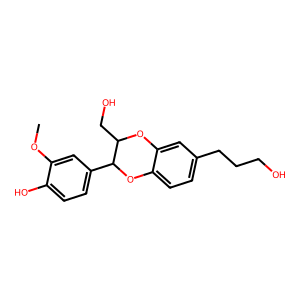

____________________incorrect retival #59________________________
Ground Truth NMR


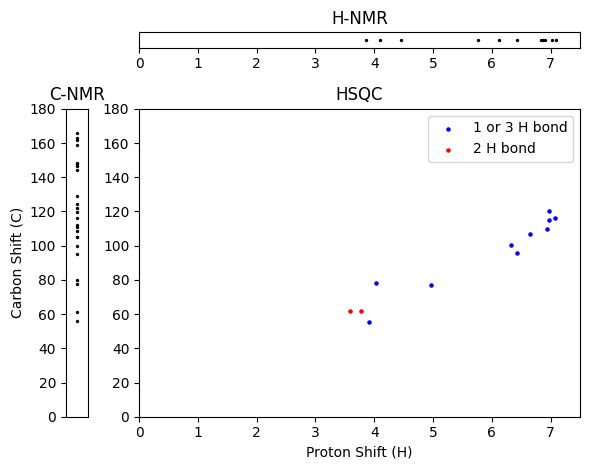

Prediction's cosine similarity to ground truth:  0.9561770558357239
Chemical name (-)-Hydnocarpin
Ground truth smiles COc1cc(C2Oc3ccc(-c4cc(=O)c5c(O)cc(O)cc5o4)cc3OC2CO)ccc1O


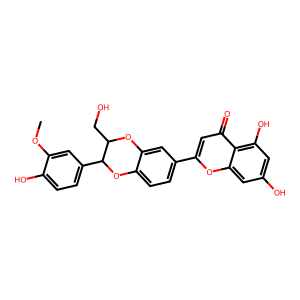

SMILES: COc1cc(C2Oc3cc(-c4cc(=O)c5c(O)cc(O)cc5o4)ccc3OC2CO)ccc1O
Name Hydnocarpin


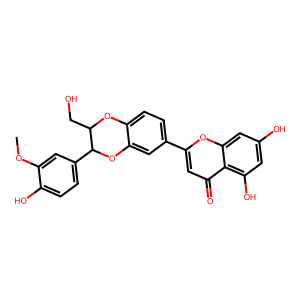

____________________incorrect retival #60________________________
Ground Truth NMR


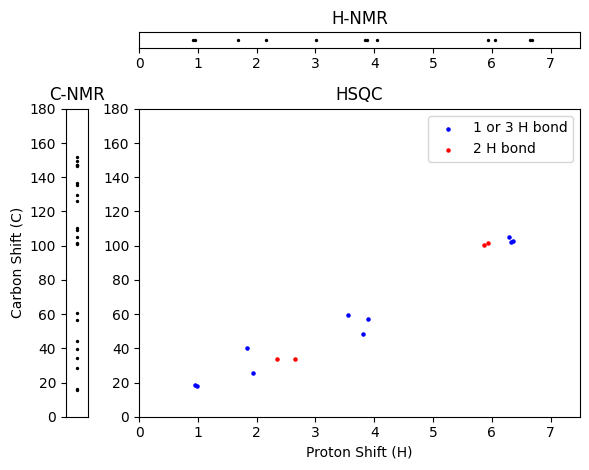

Prediction's cosine similarity to ground truth:  0.867066502571106
Chemical name 1149351-53-0
Ground truth smiles COc1cc(C2c3c(cc4c(c3OC)OCO4)CC(C)C2C)cc2c1OCO2


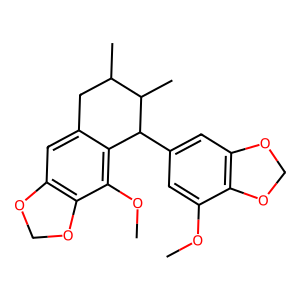

SMILES: COc1cc(C2c3c(cc(OC)c(OC)c3O)CC(C)C2C)cc2c1OCO2
Name kadsuralignan H


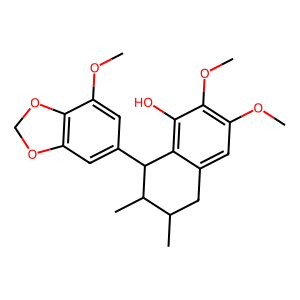

____________________incorrect retival #61________________________
Ground Truth NMR


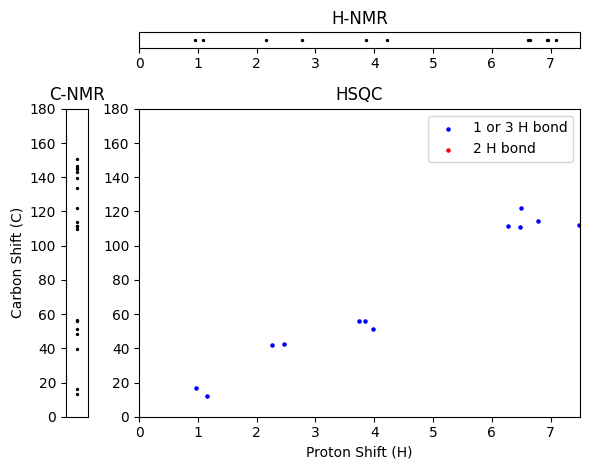

Prediction's cosine similarity to ground truth:  0.925000011920929
Chemical name 117047-78-6
Ground truth smiles COc1cc(C2c3cc(OC)c(O)cc3C(=O)C(C)C2C)ccc1O


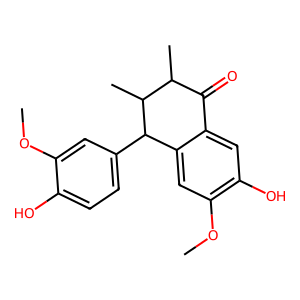

SMILES: COc1cc(C2c3cc(OC)c(OC)cc3C(=O)C(C)C2C)ccc1O
Name (-)-holostyligone


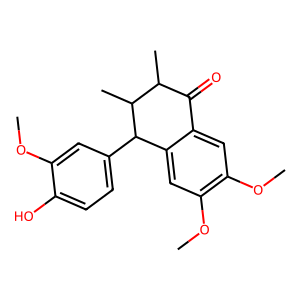

____________________incorrect retival #62________________________
Ground Truth NMR


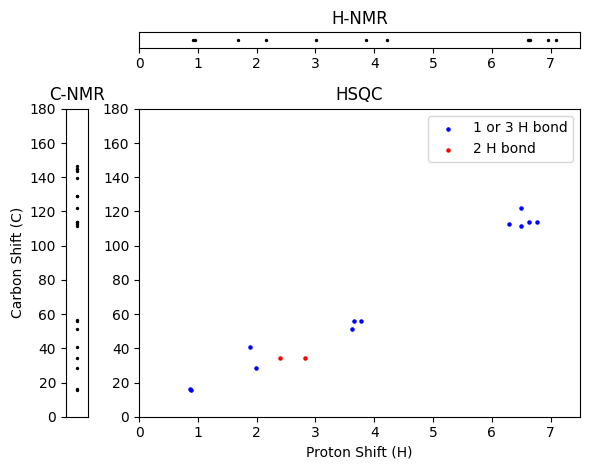

Prediction's cosine similarity to ground truth:  0.9506173133850098
Chemical name 3,4'-dihydroxy-3',4-dimethoxy-6,7'-cyclolignan
Ground truth smiles COc1cc(C2c3cc(OC)c(O)cc3CC(C)C2C)ccc1O


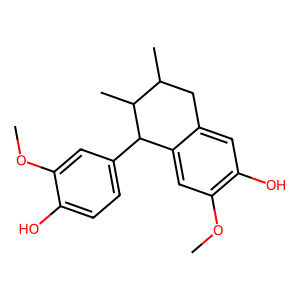

SMILES: COc1cc(C2c3cc(O)c(OC)cc3CC(C)C2C)ccc1O
Name (+)-Guaiacin


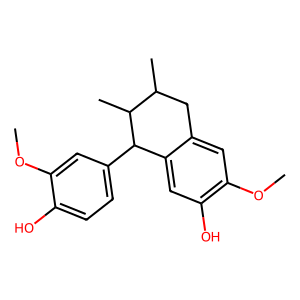

____________________incorrect retival #63________________________
Ground Truth NMR


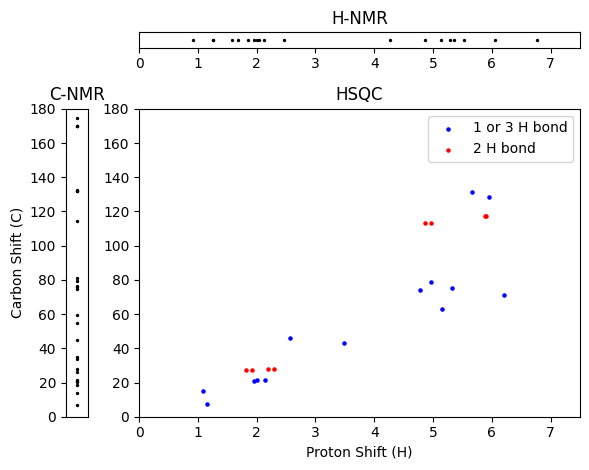

Prediction's cosine similarity to ground truth:  0.8516665101051331
Chemical name robustolide B. Juncin B
Ground truth smiles C=C1C=CC(OC(C)=O)C2(C)C(OC(C)=O)CCC(C)C2C(OC(C)=O)C2(O)C(C)C(=O)OC2C1Cl


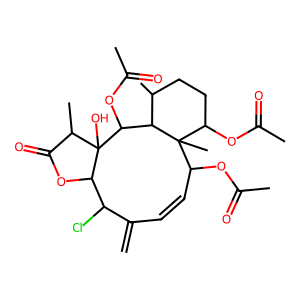

SMILES: C=C1C=CC(OC(C)=O)C2(C)C(OC(C)=O)CCC(=C)C2C(OC(C)=O)C2(O)C(C)C(=O)OC2C1Cl
Name junceellolide B


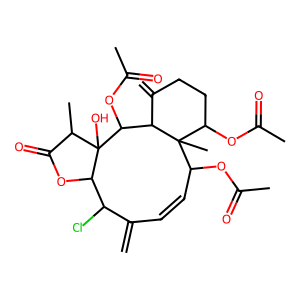

____________________incorrect retival #64________________________
Ground Truth NMR


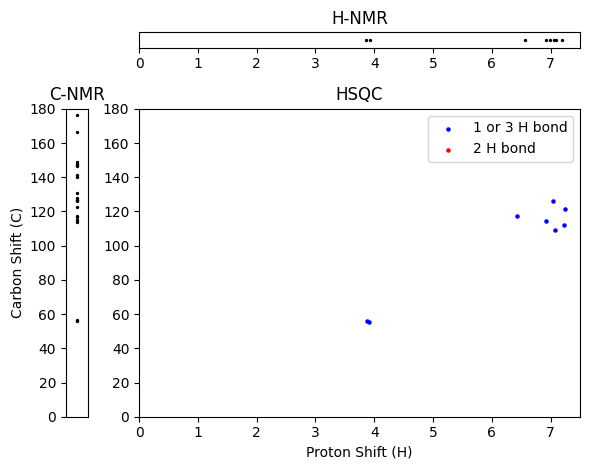

Prediction's cosine similarity to ground truth:  0.883020281791687
Chemical name (7E,7'E)-8,5'-diferulic acid
Ground truth smiles COc1cc(C=C(C(=O)O)c2cc(C=CC(=O)O)cc(OC)c2O)ccc1O


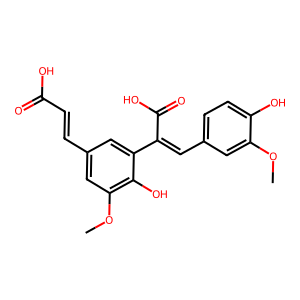

SMILES: COc1cc(C=CC(=O)O)ccc1O
Name ferulic acid


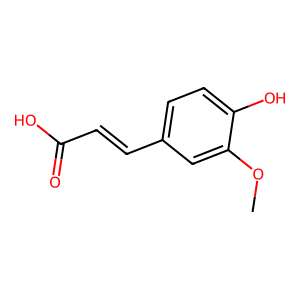

____________________incorrect retival #65________________________
Ground Truth NMR


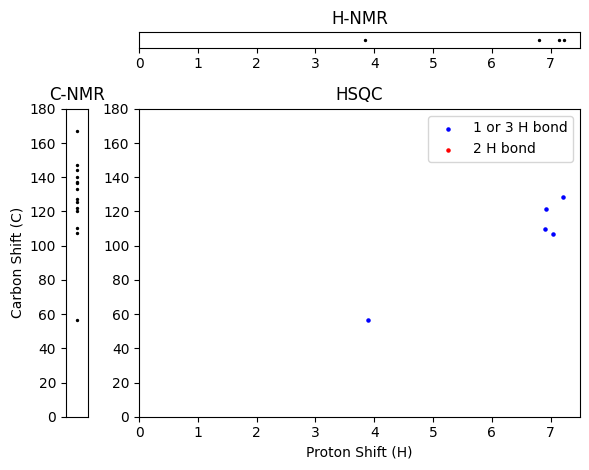

Prediction's cosine similarity to ground truth:  0.7300628423690796
Chemical name (Z)-3-(4-Hydroxy-3,5-Dimethoxybenzylidene)Indolin-2-One
Ground truth smiles COc1cc(C=C2C(=O)Nc3ccccc32)cc(OC)c1O


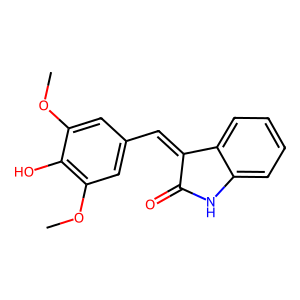

SMILES: COc1cc2c3c(cc4c(OC)cccc4c3c1O)NC2=O
Name 240122-32-1


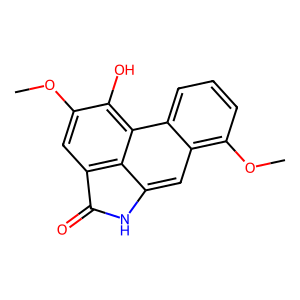

____________________incorrect retival #66________________________
Ground Truth NMR


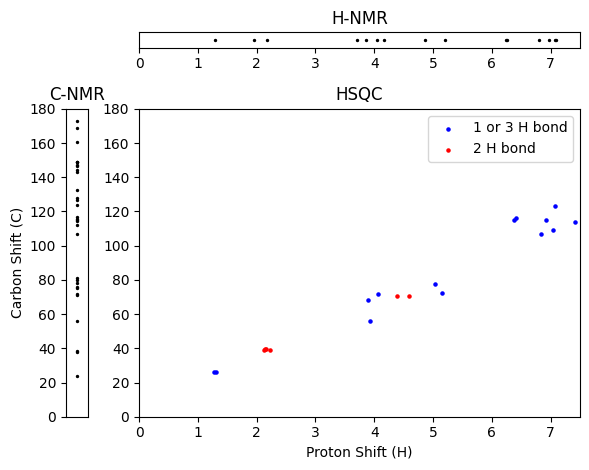

Prediction's cosine similarity to ground truth:  0.8356685638427734
Chemical name 101502035
Ground truth smiles COc1cc(C=CC(=O)OC2CC(O)(C(=O)OC(COc3c4occc4cc4ccc(=O)oc34)C(C)(C)O)CC(O)C2O)ccc1O


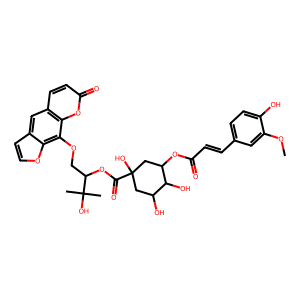

SMILES: COc1cc(C=CC(=O)OC2CC(O)(C(=O)OC(Cc3c(OC)cc4oc(=O)ccc4c3OC)C(C)(C)O)CC(O)C2O)ccc1O
Name Chemspider_Toddalin A


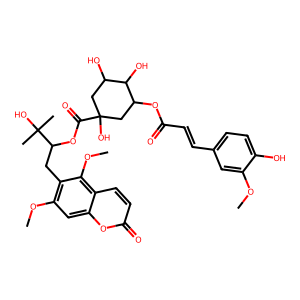

____________________incorrect retival #67________________________
Ground Truth NMR


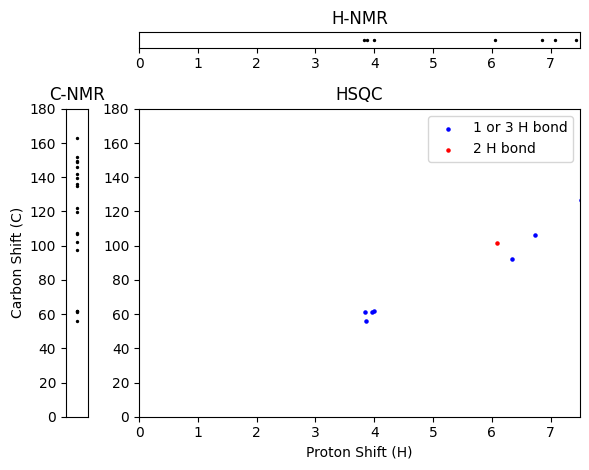

Prediction's cosine similarity to ground truth:  0.8591525554656982
Chemical name 121697-07-2
Ground truth smiles COc1cc(C=CC(=O)c2c(O)cc3c(c2OC)OCO3)c(O)c(OC)c1OC


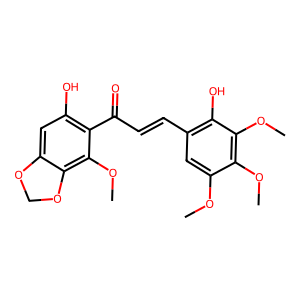

SMILES: COc1cc(C=CC(=O)c2c(O)cc3c(c2OC)OCO3)c(OC)c(OC)c1OC
Name 6'-Hydroxy-2,3,4,5,2'-pentamethoxy-3',4'-methylenedioxychalcone


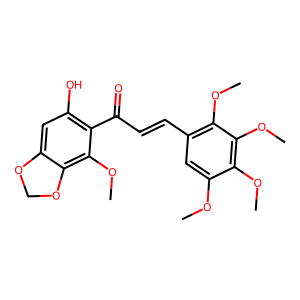

____________________incorrect retival #68________________________
Ground Truth NMR


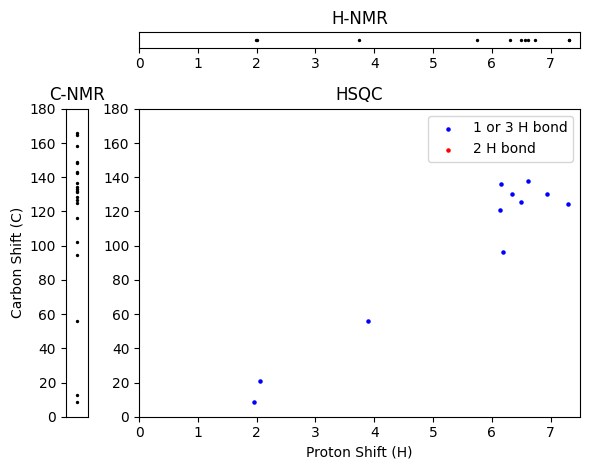

Prediction's cosine similarity to ground truth:  0.9140000343322754
Chemical name 53493724
Ground truth smiles COc1cc(C=CC(C)=CC=CC=Cc2cccnc2)oc(=O)c1C


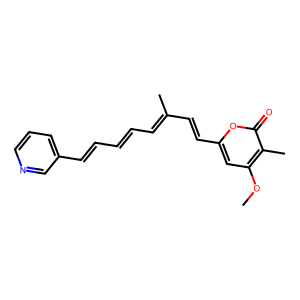

SMILES: COc1cc(C=CC=CC(C)=CC=Cc2cccnc2)oc(=O)c1C
Name pyridinopyrone B


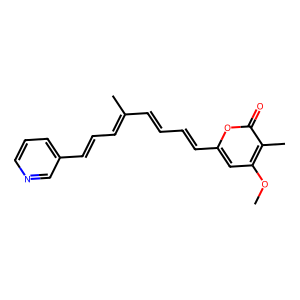

____________________incorrect retival #69________________________
Ground Truth NMR


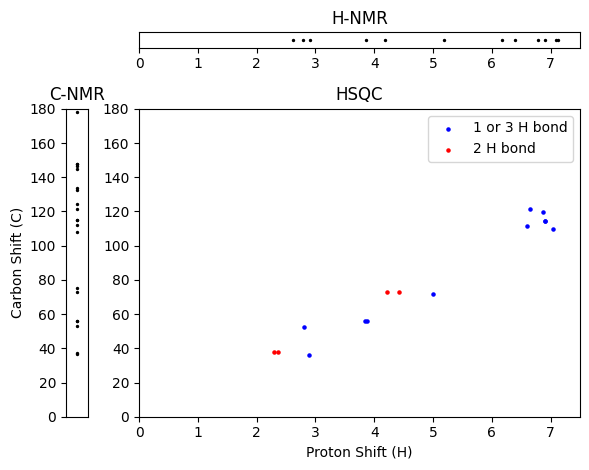

Prediction's cosine similarity to ground truth:  0.8788326978683472
Chemical name 45273284
Ground truth smiles COc1cc(CC2COC(=O)C2C(O)c2ccc(O)c(OC)c2)ccc1O


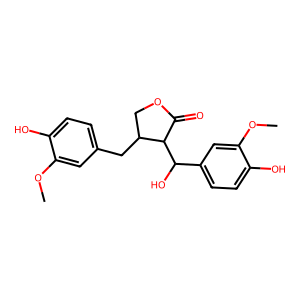

SMILES: COc1cc(CC2C(=O)OCC2C(O)c2ccc(O)c(OC)c2)ccc1O
Name Hydroxymatairesinol


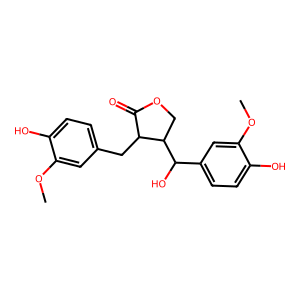

____________________incorrect retival #70________________________
Ground Truth NMR


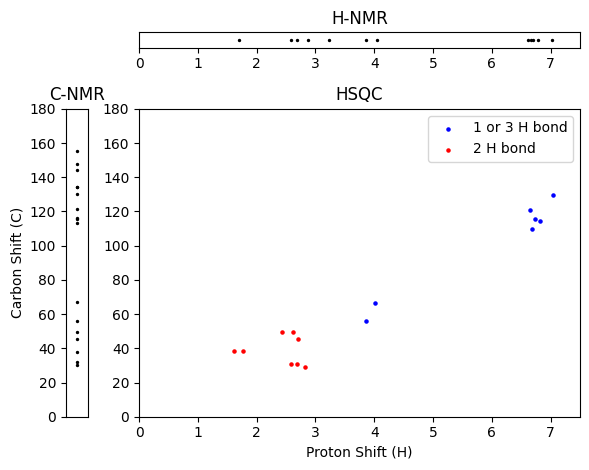

Prediction's cosine similarity to ground truth:  0.932584285736084
Chemical name (5S)-5-Hydroxy-1-(4-Hydroxy-3-Methoxyphenyl)-7-(4-Hydroxyphenyl)Heptan-3-One
Ground truth smiles COc1cc(CCC(=O)CC(O)CCc2ccc(O)cc2)ccc1O


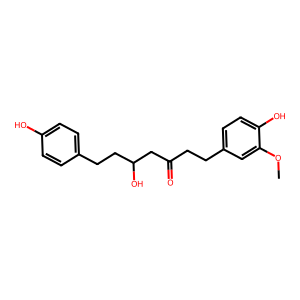

SMILES: COc1cc(CCC(O)CC(=O)CCc2ccc(O)cc2)ccc1O
Name 5-Hydroxy-7-(4-Hydroxy-3-Methoxyphenyl)-1-(4-Hydroxyphenyl)-3-Heptanone


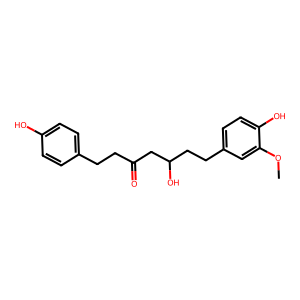

____________________incorrect retival #71________________________
Ground Truth NMR


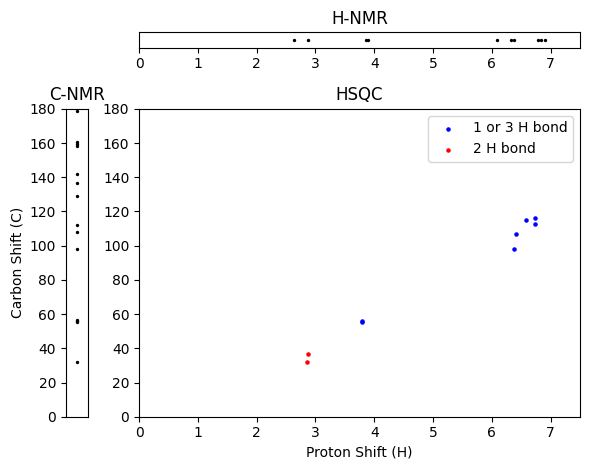

Prediction's cosine similarity to ground truth:  0.871421217918396
Chemical name 959154-96-2
Ground truth smiles COc1cc(CCc2cc(O)ccc2OC)cc(OC)c1


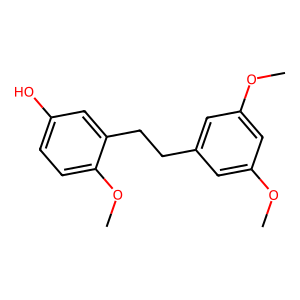

SMILES: COc1ccc(CCc2cc(O)cc(O)c2)c(OC)c1
Name stilbostemin Q


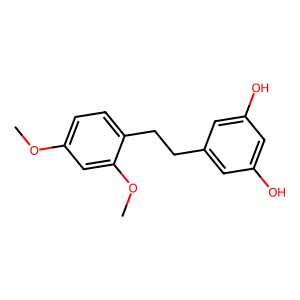

____________________incorrect retival #72________________________
Ground Truth NMR


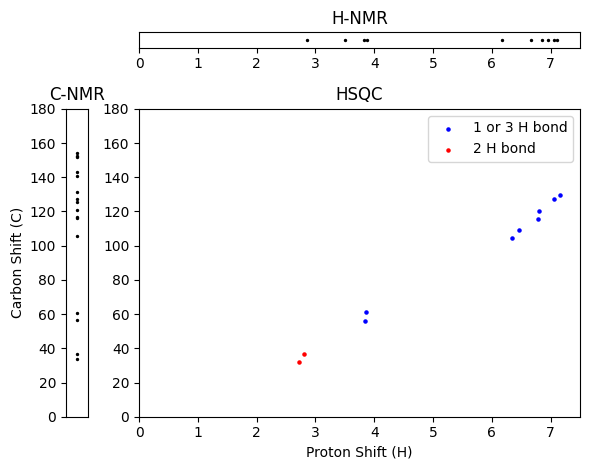

Prediction's cosine similarity to ground truth:  0.8759629130363464
Chemical name 2'-Hydroxy-3-Hydroxy-4,5-Dimethoxybibenzyl
Ground truth smiles COc1cc(CCc2ccccc2O)cc(O)c1OC


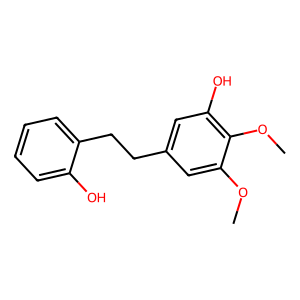

SMILES: COc1cc(CCc2ccccc2O)cc(OC)c1OC
Name Batatasin V


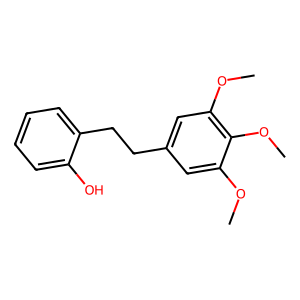

____________________incorrect retival #73________________________
Ground Truth NMR


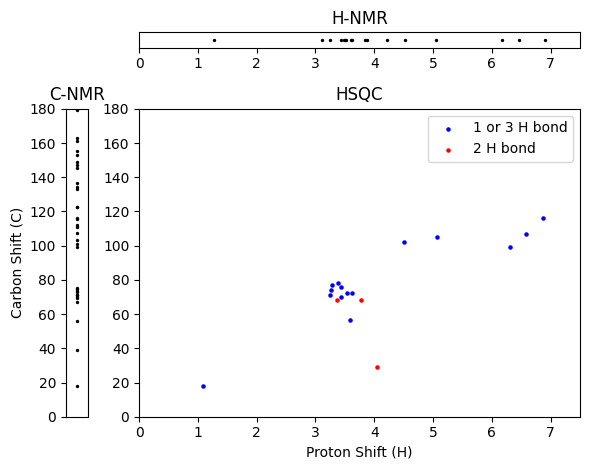

Prediction's cosine similarity to ground truth:  0.9232566356658936
Chemical name goodyerin
Ground truth smiles COc1cc(Cc2c(O)cc(O)c3c(=O)c(OC4OC(COC5OC(C)C(O)C(O)C5O)C(O)C(O)C4O)c(-c4ccc(O)c(O)c4)oc23)cc(OC)c1O


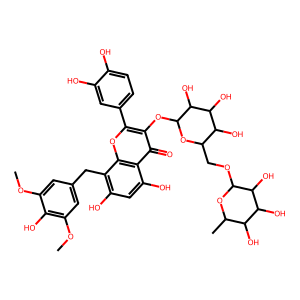

SMILES: COc1c(O)cc(O)c2c(=O)c(OC3OC(COC4OC(C)C(O)C(O)C4O)C(O)C(O)C3O)c(-c3ccc(O)c(O)c3)oc12
Name 103839-18-5


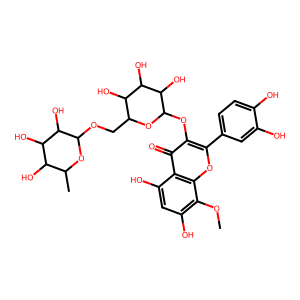

____________________incorrect retival #74________________________
Ground Truth NMR


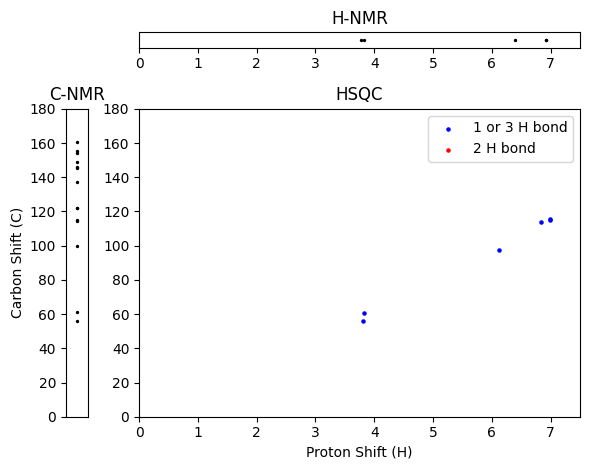

Prediction's cosine similarity to ground truth:  0.7540990114212036
Chemical name Russuphelol
Ground truth smiles COc1cc(Cl)c(Oc2c(O)cc(Oc3c(Cl)cc(O)cc3Cl)c(OC)c2Oc2c(Cl)cc(O)cc2Cl)c(Cl)c1


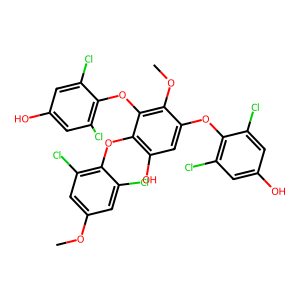

SMILES: COc1cc(-c2cc(O)c(OC)c(OC)c2)cc(O)c1OC
Name NCGC00179911-02!5-(3-hydroxy-4,5-dimethoxyphenyl)-2,3-dimethoxyphenol


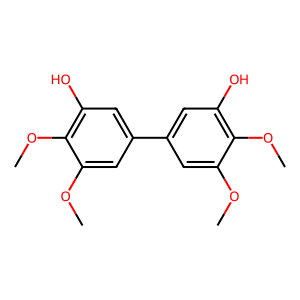

____________________incorrect retival #75________________________
Ground Truth NMR


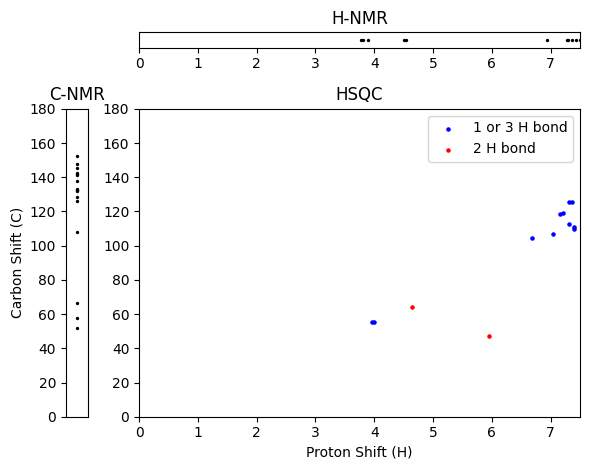

Prediction's cosine similarity to ground truth:  0.8054494261741638
Chemical name Bismurrayafolinol
Ground truth smiles COc1cc(Cn2c3ccccc3c3cc(CO)cc(OC)c32)cc2c1[nH]c1ccccc12


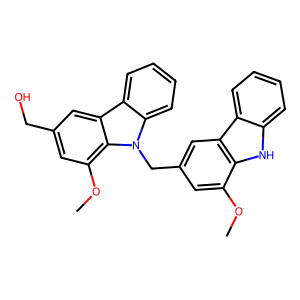

SMILES: COc1cc(CO)cc2c1[nH]c1ccccc12
Name Koenoline


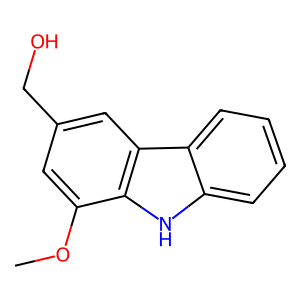

____________________incorrect retival #76________________________
Ground Truth NMR


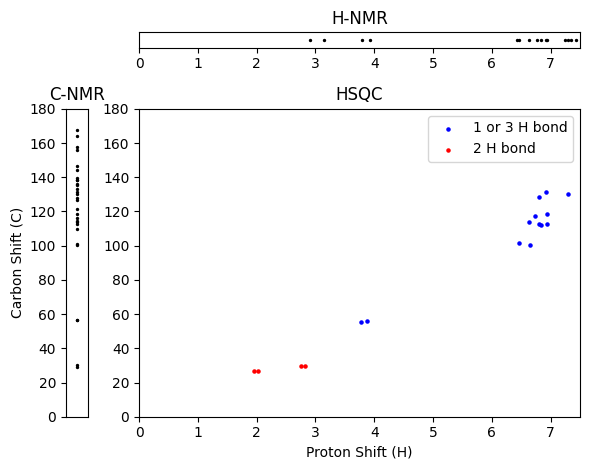

Prediction's cosine similarity to ground truth:  0.7638428211212158
Chemical name 102477418
Ground truth smiles COc1cc(O)c(-c2cc(OC)c(O)c3c2CCc2cc(O)ccc2-3)c(C=Cc2cccc(O)c2)c1


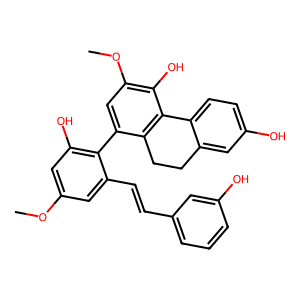

SMILES: COc1ccc2c(c1)CCc1c-2c(O)cc(O)c1-c1c(OC)cc(O)c2c1CCc1cc(O)ccc1-2
Name flavanthrin


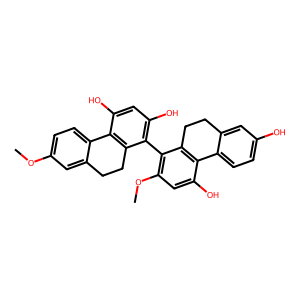

____________________incorrect retival #77________________________
Ground Truth NMR


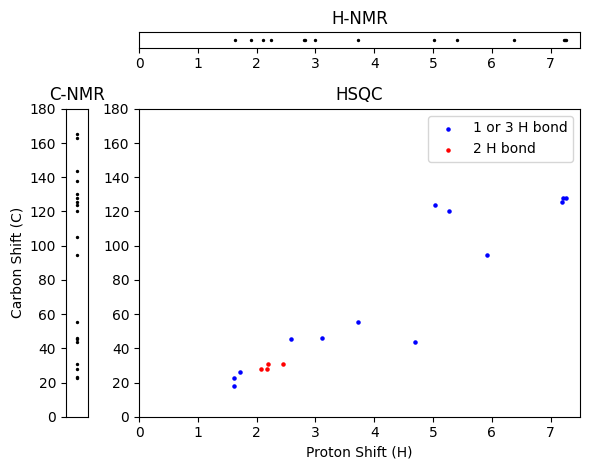

Prediction's cosine similarity to ground truth:  0.8537465929985046
Chemical name (-)-Nicolaioidesin B
Ground truth smiles COc1cc(O)c(C(=O)C2CC=C(C)C(CC=C(C)C)C2c2ccccc2)c(O)c1


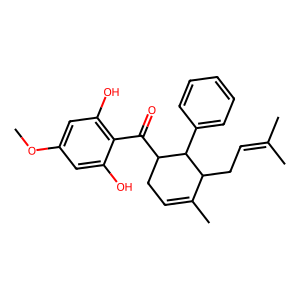

SMILES: COc1cc(O)cc(O)c1C(=O)C1C(CC=C(C)C)C(C)=CCC1c1ccccc1
Name 5-methoxy-4-[3-methyl-2-(3-methylbut-2-en-1-yl)-6-phenylcyclohex-3-ene-1-carbonyl]benzene-1,3-diol


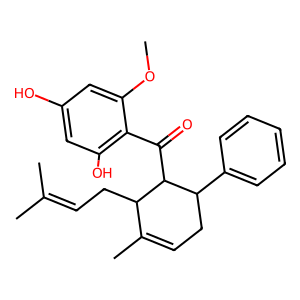

____________________incorrect retival #78________________________
Ground Truth NMR


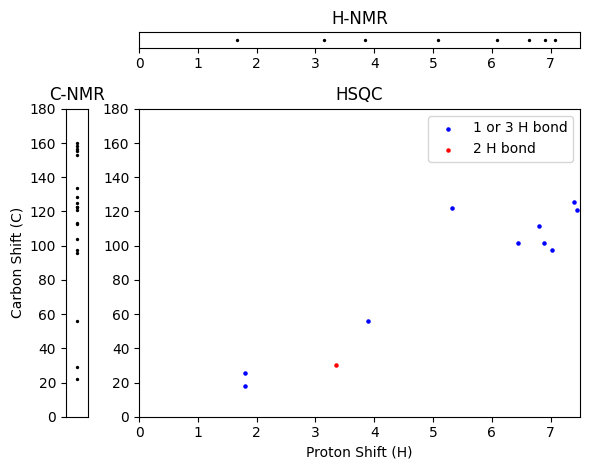

Prediction's cosine similarity to ground truth:  0.9116176962852478
Chemical name Addisofuran A
Ground truth smiles COc1cc(O)c(CC=C(C)C)cc1-c1cc2ccc(O)cc2o1


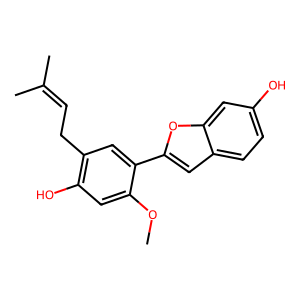

SMILES: COc1cc(O)ccc1-c1cc2cc(CC=C(C)C)c(O)cc2o1
Name Addisofuran B


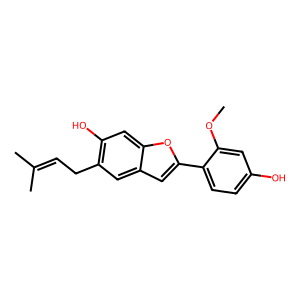

____________________incorrect retival #79________________________
Ground Truth NMR


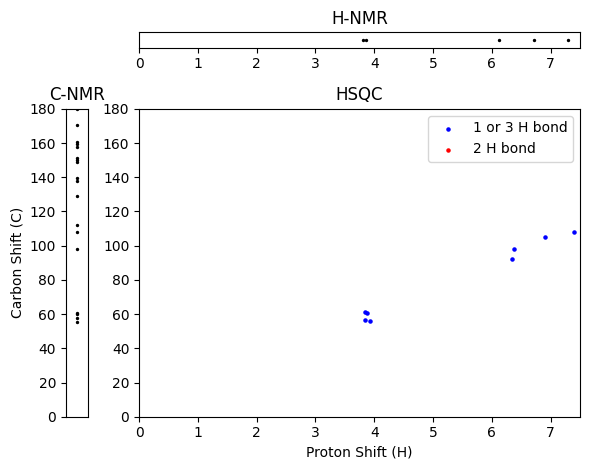

Prediction's cosine similarity to ground truth:  0.935143768787384
Chemical name 5-hydroxy-2-(3-hydroxy-4,5-dimethoxyphenyl)-3,7-dimethoxy-4H-chromen-4-one
Ground truth smiles COc1cc(O)c2c(=O)c(OC)c(-c3cc(O)c(OC)c(OC)c3)oc2c1


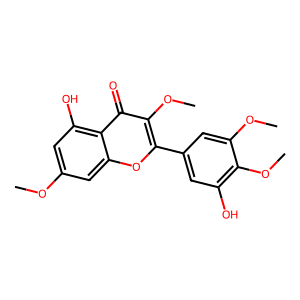

SMILES: COc1cc(O)c2c(=O)c(OC)c(-c3cc(OC)c(OC)c(OC)c3)oc2c1
Name Combretol


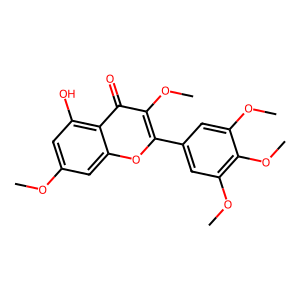

____________________incorrect retival #80________________________
Ground Truth NMR


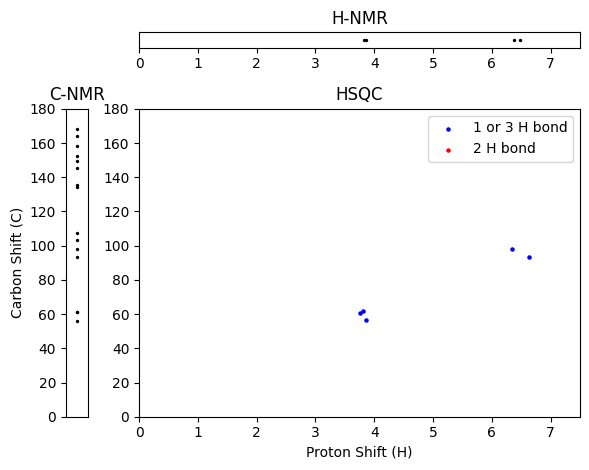

Prediction's cosine similarity to ground truth:  0.8855472803115845
Chemical name 1,5,8-trihydroxy-3,6,7-trimethoxyxanthone
Ground truth smiles COc1cc(O)c2c(=O)c3c(O)c(OC)c(OC)c(O)c3oc2c1


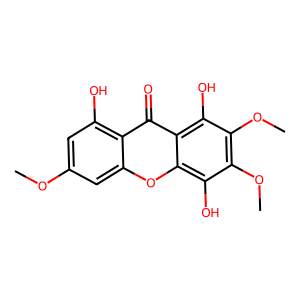

SMILES: COc1cc(O)c2c(=O)c3c(O)cc(OC)cc3oc2c1
Name 1,8-dihydroxy-3,6-dimethoxyxanthen-9-one


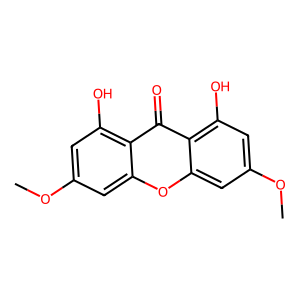

____________________incorrect retival #81________________________
Ground Truth NMR


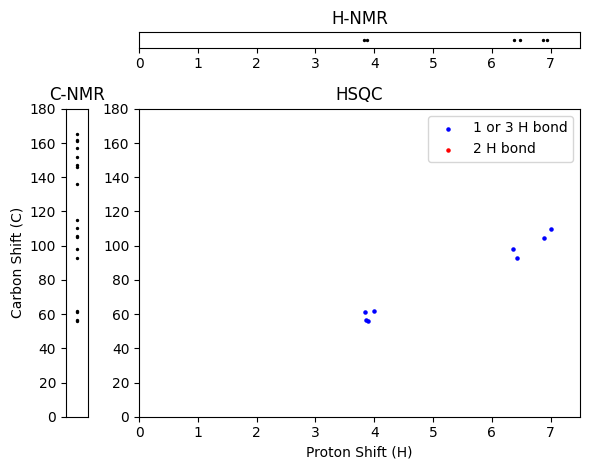

Prediction's cosine similarity to ground truth:  0.9365903735160828
Chemical name 1415341-75-1
Ground truth smiles COc1cc(O)c2c(=O)cc(-c3cc(OC)c(OC)c(OC)c3O)oc2c1


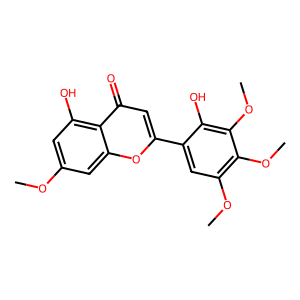

SMILES: COc1cc(O)c2c(=O)cc(-c3cc(OC)c(O)c(OC)c3OC)oc2c1
Name 352284-01-6


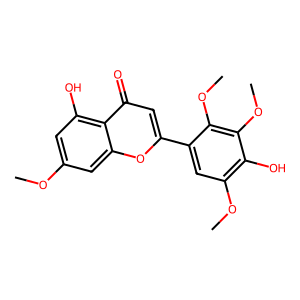

In [27]:
'''
Show only incorrect inference examples
'''

# model.to("cuda")
i=0
for idx, batch in enumerate(loader_all_inputs):
    
    inputs, (smiles_chemical_name) = batch
    hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
    inputs = inputs.to("cuda")
    pred = model(inputs)
    pred=torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())

    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    # ground truth
    smiles, names, path = zip(*smiles_chemical_name)
    
    ground_truth_smiles = smiles[0]
    
    
    for value, (smile, name, _, _), retrieved_FP in topk:
        if smile != ground_truth_smiles:
            i+=1
            print(f"____________________incorrect retival #{i+1}________________________")
            print("Ground Truth NMR")
            plot_NMR(hsqc, c_tensor, h_tensor)
            ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(ground_truth_smiles)
            print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
            
            
            
            mol = Chem.MolFromSmiles(smiles[0])
            print(f"Chemical name {names[0]}")
            print(f"Ground truth smiles {smiles[0]}")
            # print(f"Ground truth NMR path {path[0]}")
            img = Draw.MolToImage(mol)
            img.show()

           
            mol = Chem.MolFromSmiles(smile)
           
            print(f"SMILES: {smile}")
            print(f"Name {name}")
            img = Draw.MolToImage(mol)
            img.show()
    
    if i==80:
        break    
        
        
        


    



In [28]:
idx

315

In [18]:
def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

 

In [19]:


"""
Nice !
Now we can play with unkown molecule
"""
hsqc_mode = None
'''for a single model, show top-5'''
def show_topK(inputs, k=5, mode = hsqc_mode, ground_truth_FP=None):
    print("_________________________________________________________")

    
    inputs = inputs.unsqueeze(0).to("cuda")
    pred = model(inputs)
    pred = torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    if ground_truth_FP is not None:
        print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()))
        print("\n\n")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=k)
       
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, retrival cosine similarity to prediction: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())
        if ground_truth_FP is not None:
            retrieved_FP_6144 = torch.zeros(6144)
            retrieved_FP_6144[retrieved_FP.cpu()] = 1
            print("Retrival's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, retrieved_FP_6144))
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        hsqc_path, oned_path = smiles_to_NMR_path[smile]
        #check is path file exists
        hsqc, c_tensor, h_tensor = None, None, None
        # print("retrieved path: ",oned_path)
        if os.path.exists(hsqc_path):
            hsqc = torch.load(hsqc_path)
        if os.path.exists(oned_path):
            c_tensor, h_tensor = torch.load(oned_path)
            
        if hsqc is not None:
            if mode == "no_sign":
                hsqc = torch.abs(hsqc)
            elif mode == "flip_sign":
                hsqc[:,2] = -hsqc[:,2]
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [20]:
def build_input(compound_dir, mode = hsqc_mode, include_hsqc = True, include_c_nmr = True, include_h_nmr = True):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    input_NMRs = []
    if include_hsqc:
        input_NMRs+= [get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end")]
    if include_c_nmr:
        input_NMRs+= [get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end")]
    if include_h_nmr:
        input_NMRs+= [get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end")]
    inputs = torch.vstack(input_NMRs)   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    # plot_NMR(hsqc, c_tensor[:,0], h_tensor[:,0])
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])

In [21]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

In [22]:
(newCompoundA_FP.dtype)

torch.float32

In [23]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1


____________________________retival #1, cosine similarity: 0.7337204813957214_____________________________
retrived FP [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 37, 38, 41, 42, 43, 63, 64, 65, 67, 68, 72, 73, 79, 87, 90, 113, 114, 116, 117, 119, 123, 124, 125, 128, 130, 133, 135, 136, 137, 138, 139, 143, 169, 178, 180, 181, 187, 191, 192, 193, 195, 196, 214, 217, 224, 226, 228, 230, 231, 232, 233, 237, 239, 241, 242, 244, 248, 282, 286, 287, 292, 370, 371, 373, 491, 492, 508, 516, 522, 590, 591, 592, 593, 594, 603, 620, 626, 647, 660, 661, 662, 666, 734, 750, 751, 814, 826, 846, 861, 866, 960, 1013, 1014, 1045, 1090, 1240, 1309, 1330, 1337, 1381, 1420, 1485, 1691, 1952, 2116, 2151, 2247, 2249, 2302, 2488, 2493, 2517, 2676, 2906, 2921, 3013, 3239, 3397, 3635, 3703, 3804, 3818, 3949, 4030, 4048, 4100, 4214, 4387, 4399, 4659, 4779, 4985, 5419, 5432, 5534, 5954, 6123]
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name malyngamide X


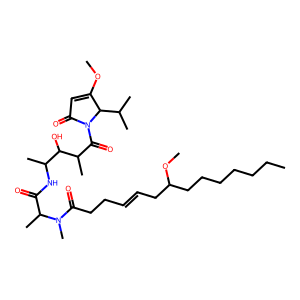

____________________________retival #2, cosine similarity: 0.6856179237365723_____________________________
retrived FP [0, 1, 5, 6, 12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 37, 38, 41, 42, 43, 63, 64, 65, 67, 68, 72, 73, 79, 87, 90, 108, 109, 110, 111, 112, 114, 116, 117, 132, 134, 135, 136, 137, 138, 139, 140, 144, 191, 192, 193, 195, 196, 214, 230, 231, 232, 233, 239, 241, 242, 244, 248, 259, 263, 280, 356, 363, 370, 371, 373, 375, 393, 404, 491, 492, 516, 522, 558, 576, 590, 591, 592, 593, 594, 603, 620, 647, 660, 661, 662, 666, 702, 713, 722, 734, 742, 750, 751, 780, 788, 792, 822, 826, 866, 942, 1024, 1143, 1217, 1284, 1330, 1381, 1421, 1441, 1504, 1637, 1685, 1691, 1867, 1950, 2040, 2133, 2151, 2247, 2265, 2442, 2488, 2493, 2647, 2807, 2891, 2921, 2953, 3121, 3334, 3421, 3652, 3742, 3949, 3952, 4100, 4214, 4399, 4642, 4673, 4730, 4963, 5316, 5432, 5534, 5832, 6107]
SMILES: CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)NC(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
Name 102147668


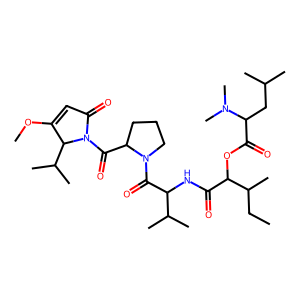

In [24]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)

In [25]:
deepSAT_sintokamide_B_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES("CCC(=O)N[C@H](C[C@H](C)C(Cl)(Cl)Cl)C(=O)N1[C@H](C(=CC1=O)OC)C[C@H](C)C(Cl)(Cl)Cl")
compute_cos_sim(deepSAT_sintokamide_B_FP, Kavaratamide_A_FP)

tensor(0.6227116585)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.5357279778)



____________________________retival #1, retrival cosine similarity to prediction: 0.695520281791687_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4265744090)
SMILES: CC(O)CCCCC(C)C1CC(O)C(C)C(=O)NC(Cc2ccccc2)C(=O)N(C)C(C(C)C)C(=O)O1
Name Colletopeptide C


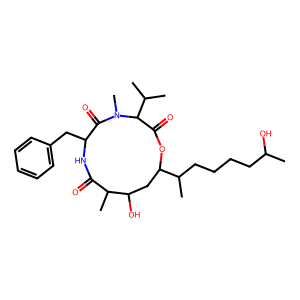

____________________________retival #2, retrival cosine similarity to prediction: 0.6857365965843201_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4100719392)
SMILES: CCC(C)C1C(=O)OC(CCCCCC(C)O)CC(O)C(C)C(=O)NC(Cc2ccccc2)C(=O)N1C
Name Colletopeptide D


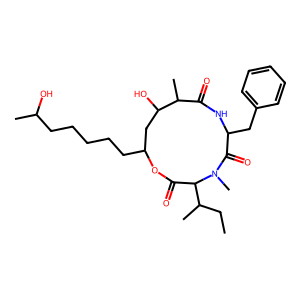

____________________________retival #3, retrival cosine similarity to prediction: 0.6800001263618469_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4072969556)
SMILES: CCC(C)C1C(=O)OC(C(C)CCCCC(C)O)CC(O)C(C)C(=O)NC(Cc2ccccc2)C(=O)N1C
Name Colletopeptide A


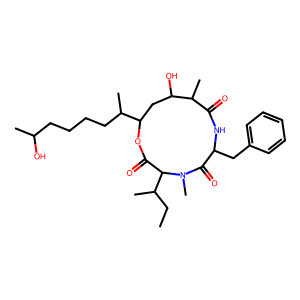

____________________________retival #4, retrival cosine similarity to prediction: 0.6662899255752563_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4314522743)
SMILES: CCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(CCCC)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name (-)-Micropeptin E


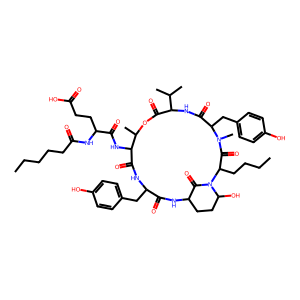

____________________________retival #5, retrival cosine similarity to prediction: 0.665851354598999_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4365206063)
SMILES: CCCCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(CCCC)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name (-)-Micropeptin F


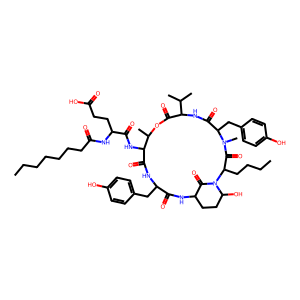

In [26]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs = build_input(compound_dir, mode=mode,
                    #  include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5, mode=mode, ground_truth_FP = Kavaratamide_A_FP)
# show_topK(inputs, k=1)

____________________________retival #1, cosine similarity: 0.8387963771820068_____________________________
retrived FP [0, 1, 2, 3, 5, 7, 11, 12, 13, 14, 15, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37, 38, 41, 42, 43, 51, 52, 53, 54, 55, 63, 64, 65, 67, 68, 87, 89, 90, 91, 102, 108, 109, 110, 111, 112, 114, 116, 117, 133, 135, 136, 137, 138, 139, 143, 147, 149, 150, 153, 154, 161, 163, 164, 165, 169, 191, 192, 193, 195, 196, 206, 207, 210, 214, 224, 226, 230, 231, 232, 233, 236, 239, 241, 242, 250, 257, 268, 309, 311, 314, 319, 321, 325, 336, 346, 347, 349, 355, 368, 370, 371, 373, 375, 376, 389, 393, 401, 404, 497, 510, 564, 590, 591, 592, 593, 594, 597, 603, 620, 621, 625, 633, 647, 660, 661, 662, 668, 669, 734, 781, 814, 815, 830, 831, 836, 841, 876, 898, 907, 909, 952, 960, 962, 966, 969, 981, 984, 1009, 1014, 1021, 1022, 1023, 1059, 1068, 1093, 1176, 1182, 1206, 1256, 1273, 1399, 1416, 1417, 1432, 1484, 1499, 1561, 1565, 1591, 1609, 1674, 1691, 1716, 1717, 1725, 1792, 1897, 1980, 

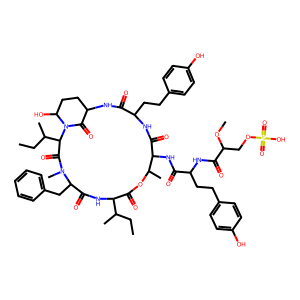

____________________________retival #2, cosine similarity: 0.8315175175666809_____________________________
retrived FP [0, 1, 2, 3, 5, 7, 11, 12, 13, 14, 15, 26, 27, 28, 29, 30, 31, 32, 33, 37, 38, 41, 42, 43, 51, 52, 53, 54, 55, 63, 64, 65, 67, 68, 87, 89, 90, 91, 102, 108, 109, 110, 111, 112, 113, 114, 116, 117, 123, 133, 135, 136, 137, 138, 139, 143, 150, 154, 161, 163, 164, 165, 169, 191, 192, 193, 195, 196, 206, 207, 210, 214, 224, 226, 230, 231, 232, 233, 239, 241, 242, 250, 257, 268, 269, 309, 311, 319, 321, 325, 334, 336, 343, 344, 345, 346, 347, 349, 355, 368, 370, 371, 373, 375, 376, 393, 401, 404, 497, 510, 564, 590, 591, 592, 593, 594, 597, 603, 620, 621, 625, 633, 647, 660, 661, 662, 668, 669, 734, 781, 814, 815, 830, 831, 836, 841, 871, 876, 898, 907, 909, 935, 952, 960, 962, 966, 969, 981, 984, 1009, 1014, 1021, 1022, 1023, 1059, 1068, 1093, 1176, 1182, 1206, 1256, 1273, 1313, 1399, 1416, 1417, 1484, 1499, 1561, 1565, 1591, 1609, 1674, 1684, 1691, 1716, 1717, 1725, 1736,

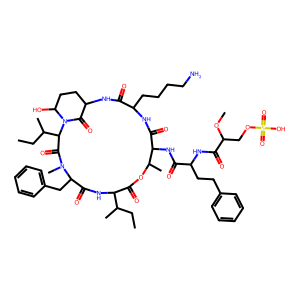

In [27]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6229786277)



____________________________retival #1, retrival cosine similarity to prediction: 0.7150909900665283_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.7245839238)
SMILES: CCC(C)C1C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC(C)C(NC(=O)C(CC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(=O)NC(CC(C)C)C(=O)NC2CCC(OC)N1C2=O
Name Micropeptin KB992


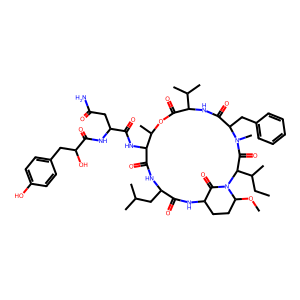

____________________________retival #2, retrival cosine similarity to prediction: 0.714163064956665_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.7223570347)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name micropeptin MZ859


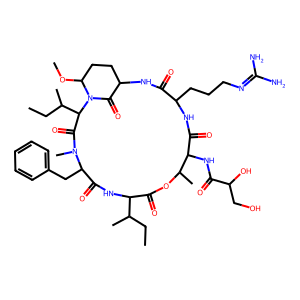

____________________________retival #3, retrival cosine similarity to prediction: 0.7128043174743652_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.7590496540)
SMILES: CCCC(=O)NC(Cc1ccc(O)cc1)C(=O)NC(CCC(=O)NC1C(=O)NC(CCCN=C(N)N)C(=O)NC2CCC(O)N(C2=O)C(C(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)CC)C(=O)OC1C)C(=O)OC
Name Micropeptin 1120


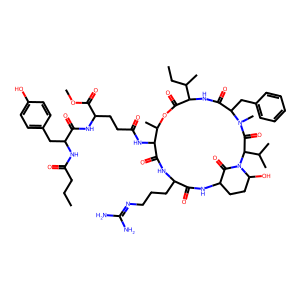

In [28]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
inputs = build_input(compound_dir)
show_topK(inputs, k=3, ground_truth_FP=newCompoundA_FP)




new_compound_B1


_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7181369066238403_____________________________
SMILES: CC=C(NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C1CCCN1C(=O)C(=CC)NC(=O)CC(O)CCCCC)C(C)C)C(C)C)C(C)C)C(C)C)C(=O)NC1C(=O)NC(C(C)C)C(=O)NC(CCO)C(=O)NC(CCN)C(=O)NC(CCCCN)C(=O)OC1C
Name Tolaasin B


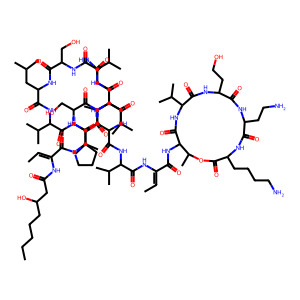

____________________________retival #2, retrival cosine similarity to prediction: 0.7099699378013611_____________________________
SMILES: CCCCCCCCCCCCCCC(=O)NC(CCCN)C(=O)NC(C(=O)NC1C(=O)NC(CCCN)C(=O)NC(CO)C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(CO)C(=O)NC(C(C)CC)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(C(C)CC)C(=O)OC1C)C(C)C
Name Paenibacterin


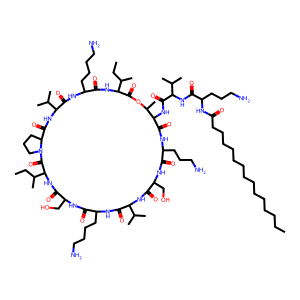

____________________________retival #3, retrival cosine similarity to prediction: 0.7076157331466675_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide T


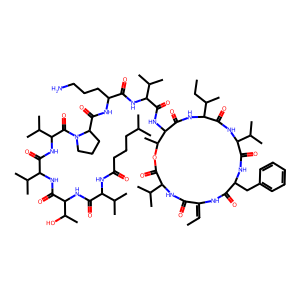

In [29]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
inputs = build_input(compound_dir)
show_topK(inputs, k=3)




new_compound_B2


_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7942517995834351_____________________________
SMILES: CCC(C)C1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name Xentrivalpeptide N


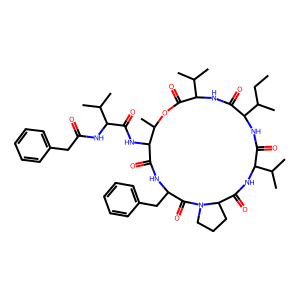

____________________________retival #2, retrival cosine similarity to prediction: 0.7902073860168457_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name xentrivalpeptide D


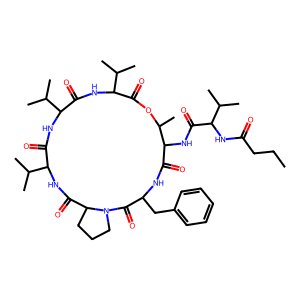

____________________________retival #3, retrival cosine similarity to prediction: 0.7809265851974487_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CC)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide P


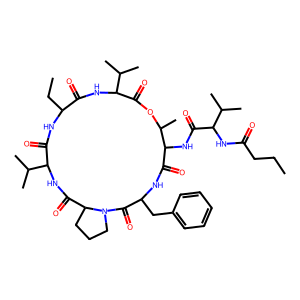

____________________________retival #4, retrival cosine similarity to prediction: 0.7765990495681763_____________________________
SMILES: CC(C)CC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide E


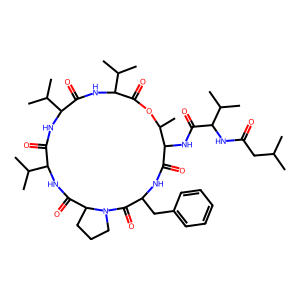

____________________________retival #5, retrival cosine similarity to prediction: 0.7763855457305908_____________________________
SMILES: CCCCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide G


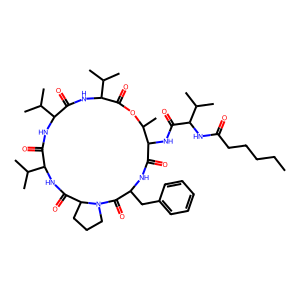

____________________________retival #6, retrival cosine similarity to prediction: 0.7755466103553772_____________________________
SMILES: CCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide C


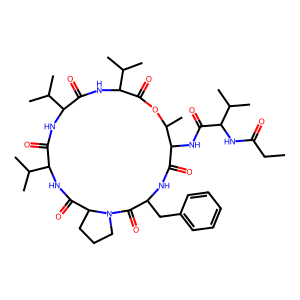

____________________________retival #7, retrival cosine similarity to prediction: 0.7707817554473877_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name 1401343-49-4


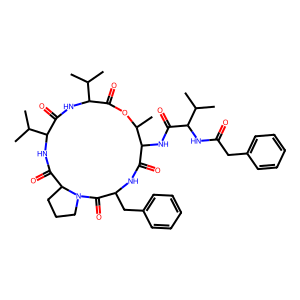

____________________________retival #8, retrival cosine similarity to prediction: 0.7707817554473877_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name xentrivalpeptide A


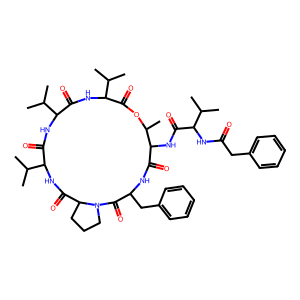

____________________________retival #9, retrival cosine similarity to prediction: 0.7683842778205872_____________________________
SMILES: CCC1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name Xentrivalpeptide O


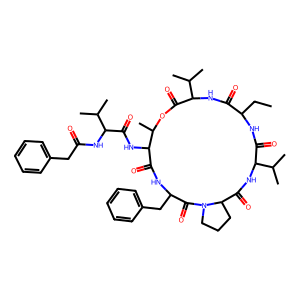

____________________________retival #10, retrival cosine similarity to prediction: 0.7649033069610596_____________________________
SMILES: CC(C)CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide F


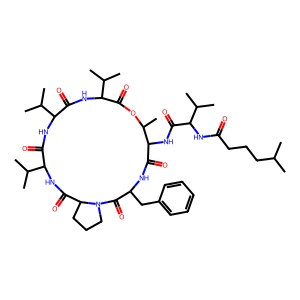

____________________________retival #11, retrival cosine similarity to prediction: 0.7648317217826843_____________________________
SMILES: CC(C)CC1NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C2CCCN2C1=O
Name Xentrivalpeptide L


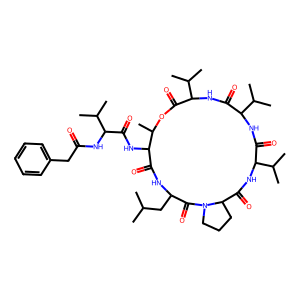

____________________________retival #12, retrival cosine similarity to prediction: 0.7626270055770874_____________________________
SMILES: CCC(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name Xentrivalpeptide H


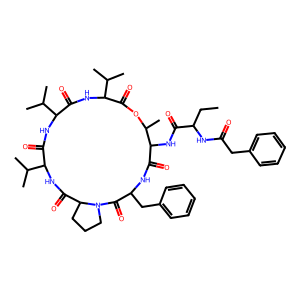

____________________________retival #13, retrival cosine similarity to prediction: 0.7613438963890076_____________________________
SMILES: CCC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name Xentrivalpeptide I


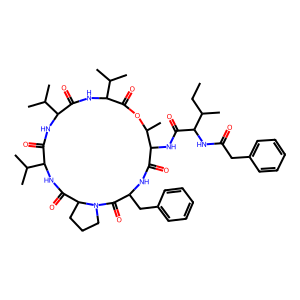

____________________________retival #14, retrival cosine similarity to prediction: 0.7592958211898804_____________________________
SMILES: CC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide B


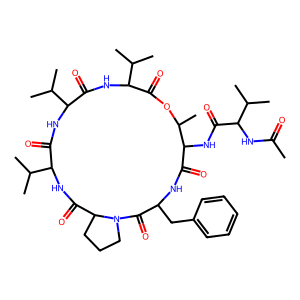

____________________________retival #15, retrival cosine similarity to prediction: 0.7471030950546265_____________________________
SMILES: CCC(C)C1NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C1=O
Name aspergillicin D


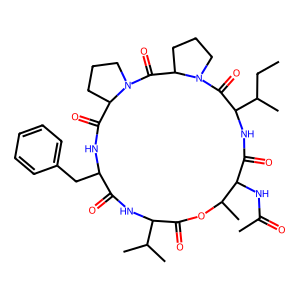

____________________________retival #16, retrival cosine similarity to prediction: 0.7386513948440552_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide J


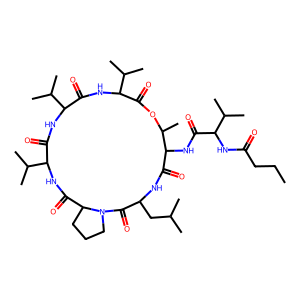

____________________________retival #17, retrival cosine similarity to prediction: 0.7376406192779541_____________________________
SMILES: CCC(C)C1NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccccc2)N(C)C(=O)C2CCCN2C(=O)C2CCCN2C1=O
Name aspergillicin C


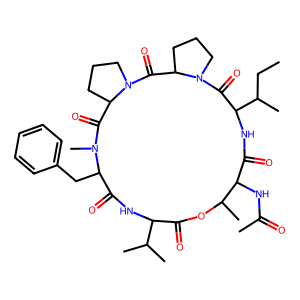

____________________________retival #18, retrival cosine similarity to prediction: 0.7254509329795837_____________________________
SMILES: CC(C)CC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide K


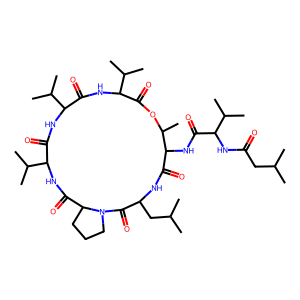

____________________________retival #19, retrival cosine similarity to prediction: 0.720117449760437_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)NC2CCC(O)N(C2=O)C(CC(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Tasipeptin A


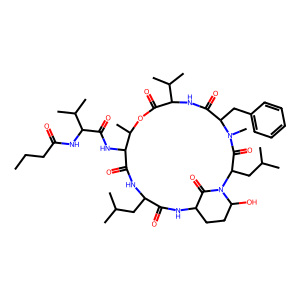

____________________________retival #20, retrival cosine similarity to prediction: 0.7188552021980286_____________________________
SMILES: CCC(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)N2CCCC2C(=O)OC1C
Name Octaminomycin A


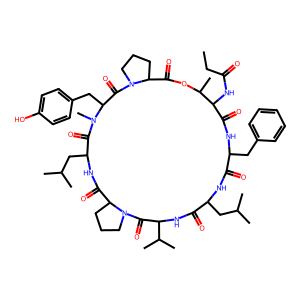

____________________________retival #21, retrival cosine similarity to prediction: 0.7143036127090454_____________________________
SMILES: CCC(C)C1NC(=O)C2CCCN2C(=O)C(C)NC(=O)C2CCCN2C(=O)C(C(C)O)NC(=O)C(Cc2ccccc2)NC(=O)C(C)NC(=O)C(C)NC(=O)C(C(C)C)NC1=O
Name cycloleonuripeptide E


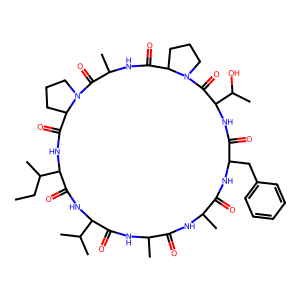

____________________________retival #22, retrival cosine similarity to prediction: 0.7140231728553772_____________________________
SMILES: CC=C1NC(=O)C(NC(=O)C(NC(=O)C(C)NC(=O)CCC)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC1=O
Name lyngbyastatin 9


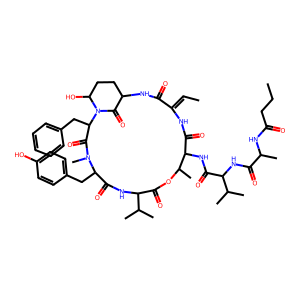

____________________________retival #23, retrival cosine similarity to prediction: 0.7137734889984131_____________________________
SMILES: CC(C)CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide M


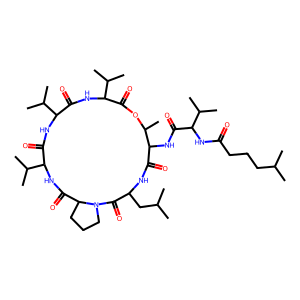

____________________________retival #24, retrival cosine similarity to prediction: 0.7122212648391724_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide T


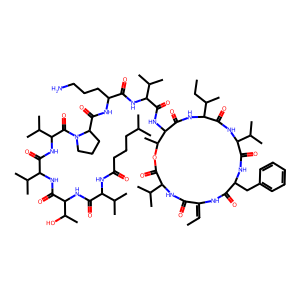

____________________________retival #25, retrival cosine similarity to prediction: 0.7081327438354492_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide F


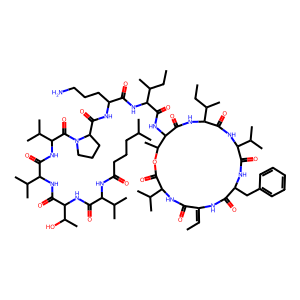

____________________________retival #26, retrival cosine similarity to prediction: 0.7068798542022705_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide U


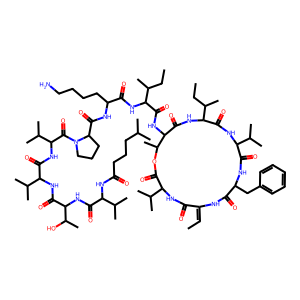

____________________________retival #27, retrival cosine similarity to prediction: 0.705194890499115_____________________________
SMILES: CC(=O)NC1C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(Cc2ccc(O)cc2)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C)C(=O)OC1C
Name FJ120DPA


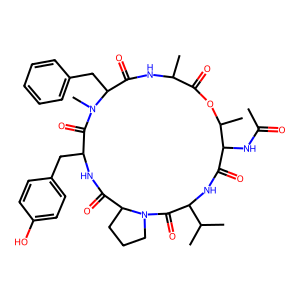

____________________________retival #28, retrival cosine similarity to prediction: 0.7043355107307434_____________________________
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(OC)cc2)NC(=O)C(NC(=O)C(NC=O)C(C)C)C(C)OC(=O)C(C(C)C)N(C)C(=O)C(CC(C)C)NC(=O)C2CCCNN2C1=O
Name marformycin A


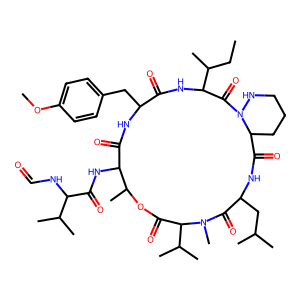

____________________________retival #29, retrival cosine similarity to prediction: 0.7034928798675537_____________________________
SMILES: CC=C1NC(=O)C(NC(=O)C(NC(=O)C(C)NC(=O)CCC)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccc(O)c(Br)c2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC1=O
Name lyngbyastatin 10


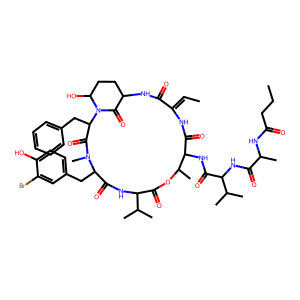

____________________________retival #30, retrival cosine similarity to prediction: 0.7027016878128052_____________________________
SMILES: CC(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)N2CCCC2C(=O)OC1C
Name Octaminomycin B


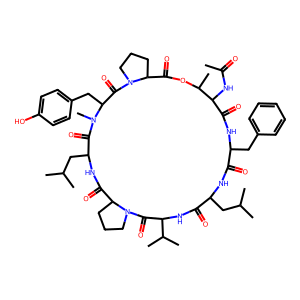

In [30]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"
inputs = build_input(compound_dir)
show_topK(inputs, k=30)